In [14]:
#!pip install scanpyad = data.copy()
#ad.raw.X.data = np.exp(ad.raw.X.data)

In [139]:
import ensembl_rest
import random
import igraph as ig
import mygene

# Operating System functionality, especially for traversing directory structures
import os
# Specialized container datatypes, i.e. specialized versions of lists, dictionaries, etc.
import collections as coll
# Date and time functions, useful for timestamping file names of figures.
import datetime
# Functional programming tools.
import itertools as itt
# Pretty-printing text by wrapping and filling lines.
import textwrap as tw

# Well-known package for n-dimensional arrays, numerical functions, linear algebra, etc.
import numpy as np
# Data analysis package.
import pandas as pd
# "Default" plotting package of Python.
import matplotlib as mpl
import matplotlib.pyplot as plt
# Matplotlib colours module.
import matplotlib.colors as mpcol
# Package improving Matplotlib's default plot style.
import seaborn as sns

# Single Cell Analysis in Python
import scanpy as sc

import anndata as ad


#for pairwise analysis - code adapted from https://www.drawingfromdata.com/ 􏰂→making-a-pairwise-distance-matrix-with-pandas
from scipy.spatial.distance import pdist 
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
#for heatmap visualization
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set(font_scale=1.5)



# Read in Deep Sequencing Data

In [2]:
#A1 = pd.read_csv('GSM1819200_expression_1.tsv', header=0, sep='\t')



In [3]:
# take in tsv of Id and count, return dataframe (right now using ensemble IDs, but having function will allow me 
#to easily change to gene names if I want to/figure out how to)
def read_bulk_data(tsv):
    _ = pd.read_csv(tsv, header=0, sep='\t')
    return _
    

In [4]:
A1 = read_bulk_data('GSM1819200_expression_1.tsv')
A2 = read_bulk_data('GSM1819201_expression_2.tsv')
A3 = read_bulk_data('GSM1819202_expression_3.tsv')
B1 = read_bulk_data('GSM1819203_expression_4.tsv')
B2 = read_bulk_data('GSM1819204_expression_5.tsv')
B3 = read_bulk_data('GSM1819205_expression_6.tsv')
C1 = read_bulk_data('GSM1819206_expression_7.tsv')
C2 = read_bulk_data('GSM1819207_expression_8.tsv')
C3 = read_bulk_data('GSM1819208_expression_9.tsv')

In [5]:
A1

Id  Count
0      ENSMUST00000000001    260
1      ENSMUST00000000003      0
2      ENSMUST00000000010      0
3      ENSMUST00000000028      9
4      ENSMUST00000000033    631
...                   ...    ...
95528  ENSMUST00000175629      0
95529  ENSMUST00000175630      0
95530  ENSMUST00000175631      0
95531  ENSMUST00000175632      0
95532  ENSMUST00000175633      0

[95533 rows x 2 columns]

In [78]:
#reading data, converting IDs, removing them if they don't have a symbol
def read_bulk_data_convert_IDs(tsv):
    df = pd.read_csv(tsv, header=0, sep='\t')
    
    mg = mygene.MyGeneInfo()
    
    ID_list = df['Id'].values.tolist()
    
    #converting header to symbol rather than ID
    mg_dataframe = mg.querymany(ID_list, scopes='ensembl.transcript', fields='symbol', species='mouse', as_dataframe=True)
    symbol_list = mg_dataframe['symbol'].values.tolist()
    
    df.replace(ID_list,symbol_list) #not sure this will work
    
    #removing duplicates
    duplicates_deleted = df.drop([42530,32256])

    #removing NaN
    new_df = duplicates_deleted[duplicates_deleted['Id'] is not np.nan]
    
    return new_df

In [79]:
A1_converted = read_bulk_data_convert_IDs('GSM1819200_expression_1.tsv')
A2_converted = read_bulk_data_convert_IDs('GSM1819201_expression_2.tsv')
A3_converted = read_bulk_data_convert_IDs('GSM1819202_expression_3.tsv')
B1_converted = read_bulk_data_convert_IDs('GSM1819203_expression_4.tsv')
B2_converted = read_bulk_data_convert_IDs('GSM1819204_expression_5.tsv')
B3_converted = read_bulk_data_convert_IDs('GSM1819205_expression_6.tsv')
C1_converted = read_bulk_data_convert_IDs('GSM1819206_expression_7.tsv')
C2_converted = read_bulk_data_convert_IDs('GSM1819207_expression_8.tsv')
C3_converted = read_bulk_data_convert_IDs('GSM1819208_expression_9.tsv')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

NameError: name 'symbol_listmg_dataframe' is not defined

# Read in Single Nuclei Data - From Sara

In [6]:
%run From_Sara/scanpy_aid.py

In [7]:
input_path = 'From_Sara/replicate_2/filtered_feature_bc_matrix/'
data_r2 = read_piriform_adult(input_path)

input_path = 'From_Sara/replicate_3/filtered_feature_bc_matrix/'
data_r3 = read_piriform_adult(input_path)

# Pooling the two replicates
data = data_r2.concatenate(data_r3)

# And verifying if all went well by looking at the dimensions
print(data_r2)
print(data_r3)
print(data)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 310 × 31053 
AnnData object with n_obs × n_vars = 198 × 31053 
AnnData object with n_obs × n_vars = 508 × 31053 
    obs: 'batch'


In [8]:
import collections as coll

# Print all genes that are present more than once as (name: found x times)
tw.wrap(", ".join("{0}: {1}".format(name, ndup) 
            for name, ndup in coll.Counter(data.var_names).most_common(56)), 70)

['Xkr4: 1, Gm1992: 1, Gm37381: 1, Rp1: 1, Sox17: 1, Gm37323: 1, Mrpl15:',
 '1, Lypla1: 1, Gm37988: 1, Tcea1: 1, Rgs20: 1, Gm16041: 1, Atp6v1h: 1,',
 'Oprk1: 1, Npbwr1: 1, Rb1cc1: 1, 4732440D04Rik: 1, Alkal1: 1, St18: 1,',
 'Pcmtd1: 1, Gm26901: 1, Gm30414: 1, Sntg1: 1, Rrs1: 1, Adhfe1: 1,',
 '3110035E14Rik: 1, Gm29520: 1, Mybl1: 1, Vcpip1: 1, 1700034P13Rik: 1,',
 'Sgk3: 1, Mcmdc2: 1, Snhg6: 1, Tcf24: 1, Ppp1r42: 1, Gm15818: 1, Cops5:',
 '1, Cspp1: 1, Arfgef1: 1, Cpa6: 1, Prex2: 1, A830018L16Rik: 1, Gm17644:',
 '1, Gm29663: 1, Sulf1: 1, Slco5a1: 1, Gm29283: 1, Prdm14: 1, Ncoa2: 1,',
 'Gm29570: 1, Tram1: 1, Lactb2: 1, Xkr9: 1, Eya1: 1, Gm9947: 1, Msc: 1']

In [9]:
# Add '-1', '-2' etc. to names to make them unique
data.var_names_make_unique()
sndata = data
del data

In [10]:
sndata

AnnData object with n_obs × n_vars = 508 × 31053 
    obs: 'batch'

# Generate Simulated Nuclei

## Prep work

In [11]:
#takes in a datatable of reads per gene from bulk seq and how many genes to select returns list of genes based on 
#bulk probability (selecting multiple at once is faster)
def choose_genes(dataFrame,how_many_genes):
    list_of_candidates = []
    list_of_probabilities = []
    for index in dataFrame.index:
        list_of_candidates.append(dataFrame['Id'][index])
        list_of_probabilities.append(dataFrame['Count'][index])
    genes = random.choices(population = list_of_candidates, weights = list_of_probabilities, k = how_many_genes)        
    
    return genes
#THIS DOES RANDOM CHOICE WITH REPLACEMENT - IS THAT RIGHT? SAME NUCLEUS CAN HAVE MULTIPLE READS OF SAME GENE?

In [12]:
#calculating how many genes... aiming to do this based on distrubtion in single nuclei data
# --> so how do I get that distribution... could calculate based on each cell? that seems like it'll take a long time...
## use that weird [:] feature!!! code taken from clustering below

def calc_distr_of_how_many_genes(data): #takes in AnnData matrix, returns list of choices for random.choice    
    # Add the total counts per cell as observations-annotation to data
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    # Computing how many genes are expressed in each cell
    data.obs['n_genes'] = np.sum(data.X > 0, axis=1).A1
    
    distr = []
    for num in data.obs['n_counts']:
        distr.append(int(num))
    return distr


### Converting  ENMUST IDs to symbols

In [13]:
mg = mygene.MyGeneInfo()

#have switched ensembl and symbol to be correct
#TF_dictionary_list = mg.querymany(TFs, scopes='ensembl.gene', fields='symbol', species='mouse')

In [14]:
#all the headers will be the same, so can do it just from A1
header = A1['Id'].values.tolist()
    
#converting header to symbol rather than ID
mg_dataframe = mg.querymany(header, scopes='ensembl.transcript', fields='symbol', species='mouse', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

In [55]:
symbol_header = mg_dataframe['symbol'].values.tolist()
print(len(symbol_header))

95547


In [17]:
mg_dataframe.to_csv('dataframe to search for duplicates.csv')

In [92]:
##finding the duplicates (slow)
#dupes = [x for n, x in enumerate(ID_header) if x in ID_header[:n]]
#print(dupes)



In [56]:
#the mygene query tells you about any duplicates
#and then I just found their indices by downloading the dataframe as a csv and searching in excel
#remove the duplicates in reverse order so the indices don't get messed up
# symbol_header.pop(42530)
# symbol_header.pop(32256)
del symbol_header[86026:86029]
del symbol_header[42530:42537]
del symbol_header[32256:32260]
print(len(symbol_header))

95533


In [112]:
# #remove NaN
# for index, symbol in enumerate(symbol_header):
#     if symbol is np.nan:
#         #symbol_header[index] = header[index]
#         symbol_header.pop(index)

# print(len(symbol_header))

83045


In [62]:
#generates simulated nuclei --> returns a dataframe: each row is a simulated nucleus, each column is a gene
#dataset is string that will be set as obs
def generate_nuclei_from_bell_curve(bulkDataFrame, ID_header, sym_header, distr_of_how_many_genes, num2gen, dataset, layer, drop):
    print('this function is running: ' + dataset)
    #bulkDataFrame is how many reads were found of each gene in bulk seq data. 
    #Mean and sdev refer to normal distribution of how many different genes each cell expressed 
    #num2gen = how many simulated nuclei to generate
    
    #choiceArray = prob_of_gene_expression(bulkDataFrame)
    
    #replace NaN with ENSMUST ID (if don't have symbol)
    
    for index, symbol in enumerate(symbol_header):
        if symbol is np.nan:
            if drop == False:
                symbol_header[index] = header[index]
                #print('drop was false')
            if drop == True:
                symbol_header[index] = 'to drop'
                #print('to drop added to symbol_header')
                
    
    list_of_lists = []
    zero_list = [0] * len(header)
    for i in range(0,num2gen):
        list_of_lists.append(zero_list)
    print('list_of_lists: ' + str(len(list_of_lists)))
    df = pd.DataFrame(list_of_lists, columns=ID_header)
    #print(df)
    #add the genes - make a list
    for index in range(0,num2gen): #each simulated nucleus
        #how_many_genes = int(round(np.random.normal(mean, sdev)))
        how_many_genes = random.choice(distr_of_how_many_genes)
        genes = choose_genes(bulkDataFrame,how_many_genes)
        #print(genes)
        for gene in genes:
            df.at[index, gene] = df.at[index, gene] + 1
        print('nucleus ' + str(index) + ' done')
    #return df
    
    df.columns = sym_header #replacing column names with symbol names now that nuclei are generated
    
    #drop NaN (if no symbol, just delete it)
    if drop == True:
        df = df.T
        df = df.dropna()
        print('just did dropna')
        df = df.T
        df.drop('to drop', axis=1)
        print('dropped')
    
    ann_data = ad.AnnData(X = df)
    ann_data.obs['dataset'] = dataset
    ann_data.obs['layer'] = layer
    return ann_data
        
    #df2 = pd.DataFrame([[5, 6], [7, 8]], columns=header)
    #simulated_df.append(list)
    #print(df2)
        
    

## Actually generating the nuclei, storing in AnnData objects

In [22]:
distr_how_many = calc_distr_of_how_many_genes(sndata)


In [63]:
A1_ad = generate_nuclei_from_bell_curve(A1, header, symbol_header, distr_how_many, 2, 'A1', 'A', drop = True)
A1_ad
print(A1_ad.X)

this function is running: A1
list_of_lists: 2
nucleus 0 done


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 1 done
just did dropna
dropped
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [64]:
A1_ad

AnnData object with n_obs × n_vars = 2 × 95533 
    obs: 'dataset', 'layer'

In [65]:
A2_ad = generate_nuclei_from_bell_curve(A2, header, symbol_header, distr_how_many, 5, 'A2', 'A', drop = True)



this function is running: A2
list_of_lists: 5
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done


Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 4 done
just did dropna
dropped


In [66]:
A2_ad

AnnData object with n_obs × n_vars = 5 × 95533 
    obs: 'dataset', 'layer'

In [67]:
A1_ad.concatenate(A2_ad)

Making variable names unique for controlled concatenation.


AnnData object with n_obs × n_vars = 7 × 95533 
    obs: 'batch', 'dataset', 'layer'

In [ ]:
#B1_ad

In [96]:
A1_ad = generate_nuclei_from_bell_curve(A1, header, symbol_header, distr_how_many, 100, 'A1', 'A', drop = False)
A2_ad = generate_nuclei_from_bell_curve(A2, header, symbol_header, distr_how_many, 100, 'A2', 'A', drop = False)
A3_ad = generate_nuclei_from_bell_curve(A3, header, symbol_header, distr_how_many, 100, 'A3', 'A', drop = False)

B1_ad = generate_nuclei_from_bell_curve(B1, header, symbol_header, distr_how_many, 100, 'B1', 'B', drop = False)
B2_ad = generate_nuclei_from_bell_curve(B2, header, symbol_header, distr_how_many, 100, 'B2', 'B', drop = False)
B3_ad = generate_nuclei_from_bell_curve(B3, header, symbol_header, distr_how_many, 100, 'B3', 'B', drop = False)

C1_ad = generate_nuclei_from_bell_curve(C1, header, symbol_header, distr_how_many, 100, 'C1', 'C', drop = False)
C2_ad = generate_nuclei_from_bell_curve(C2, header, symbol_header, distr_how_many, 100, 'C2', 'C', drop = False)
C3_ad = generate_nuclei_from_bell_curve(C3, header, symbol_header, distr_how_many, 100, 'C3', 'C', drop = False)

this function is running: A1
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nucleus 59 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 99 done
this function is running: A2
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 99 done
this function is running: A3
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 99 done
this function is running: B1
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 99 done
this function is running: B2
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 99 done
this function is running: B3
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 99 done
this function is running: C1
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 99 done
this function is running: C2
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


nucleus 99 done
this function is running: C3
list_of_lists: 100
nucleus 0 done
nucleus 1 done
nucleus 2 done
nucleus 3 done
nucleus 4 done
nucleus 5 done
nucleus 6 done
nucleus 7 done
nucleus 8 done
nucleus 9 done
nucleus 10 done
nucleus 11 done
nucleus 12 done
nucleus 13 done
nucleus 14 done
nucleus 15 done
nucleus 16 done
nucleus 17 done
nucleus 18 done
nucleus 19 done
nucleus 20 done
nucleus 21 done
nucleus 22 done
nucleus 23 done
nucleus 24 done
nucleus 25 done
nucleus 26 done
nucleus 27 done
nucleus 28 done
nucleus 29 done
nucleus 30 done
nucleus 31 done
nucleus 32 done
nucleus 33 done
nucleus 34 done
nucleus 35 done
nucleus 36 done
nucleus 37 done
nucleus 38 done
nucleus 39 done
nucleus 40 done
nucleus 41 done
nucleus 42 done
nucleus 43 done
nucleus 44 done
nucleus 45 done
nucleus 46 done
nucleus 47 done
nucleus 48 done
nucleus 49 done
nucleus 50 done
nucleus 51 done
nucleus 52 done
nucleus 53 done
nucleus 54 done
nucleus 55 done
nucleus 56 done
nucleus 57 done
nucleus 58 done
nu

Transforming to str index.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
#putting layers together
#A1_ad = generate_nuclei_from_bell_curve(A1, header, symbol_header, distr_how_many, 100, 'A1')
# A2_ad = generate_nuclei_from_bell_curve(A2, header, symbol_header, distr_how_many, 100, 'A2')
# A3_ad = generate_nuclei_from_bell_curve(A3, header, symbol_header, distr_how_many, 100, 'A3')

# B1_ad = generate_nuclei_from_bell_curve(B1, header, symbol_header, distr_how_many, 100, 'B1')
# B2_ad = generate_nuclei_from_bell_curve(B2, header, symbol_header, distr_how_many, 100, 'B2')
# B3_ad = generate_nuclei_from_bell_curve(B3, header, symbol_header, distr_how_many, 100, 'B3')

# C1_ad = generate_nuclei_from_bell_curve(C1, header, symbol_header, distr_how_many, 100, 'C1')
# C2_ad = generate_nuclei_from_bell_curve(C2, header, symbol_header, distr_how_many, 100, 'C2')
# C3_ad = generate_nuclei_from_bell_curve(C3, header, symbol_header, distr_how_many, 100, 'C3')

In [30]:
#A1_ad = A1_ad[A1_ad.symbol is not np.nan]
#A1_ad.dropna()
A1_ad

AnnData object with n_obs × n_vars = 100 × 95533 
    obs: 'dataset', 'layer'

In [27]:
print(A2_ad)

AnnData object with n_obs × n_vars = 100 × 95533 
    obs: 'dataset'


In [69]:
#concatenating into one anndata
dropped_sim = A1_ad.concatenate(A2_ad,A3_ad,B1_ad,B2_ad,B3_ad,C1_ad,C2_ad,C3_ad)
dropped_sim

Making variable names unique for controlled concatenation.


AnnData object with n_obs × n_vars = 900 × 95533 
    obs: 'batch', 'dataset', 'layer'

In [97]:
#concatenating into one anndata
sim_by_layer = A1_ad.concatenate(A2_ad,A3_ad,B1_ad,B2_ad,B3_ad,C1_ad,C2_ad,C3_ad)


Making variable names unique for controlled concatenation.


In [98]:
#once nuclei are generated, saving them so I can just load them in instead of generating them again
sim_by_layer.write('simulated_piriform_nuclei_by_layer.h5ad')

... storing 'dataset' as categorical
... storing 'layer' as categorical


In [155]:
#print(simulated_df_B1.at[0,'ENSMUST00000095806'])

## Generating nuclei does work! And I think it's successfully doing it based on distribution from single nuclei data!

Storing the simulated nuclei in a pandas DataFrame - each row is a nucleus, each column in a gene

### so next step: put all the nuclei in an AnnData, with an obs for origin dataset (probably best to make each an AnnData with that obs, then concatenate)

# Clustering - From Sara

In [156]:
data = sim_data

In [242]:
sim_data = data #to deal with running everything on two different datasets (do this after have run first)

In [243]:
sim_data

AnnData object with n_obs × n_vars = 900 × 30438 
    obs: 'batch', 'dataset', 'percent_mito', 'n_counts', 'n_genes', 'louvain'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'louvain_colors', 'draw_graph', 'rank_genes_groups', 'umap', 'dataset_colors'
    obsm: 'X_pca', 'X_draw_graph_fr', 'X_draw_graph_fa', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [244]:
del data

In [33]:
sndata

AnnData object with n_obs × n_vars = 508 × 31053 
    obs: 'batch', 'n_counts', 'n_genes'

In [34]:
data = sndata

In [35]:
data

AnnData object with n_obs × n_vars = 508 × 31053 
    obs: 'batch', 'n_counts', 'n_genes'

In [36]:
# Set the cut-off
MITO_CUTOFF = 0.015

mito_genes = [name for name in data.var_names if name.startswith('mt-')]
# For each cell compute fraction of counts in mito genes vs. all genes.
# The `.A1` is only necessary because X is sparse. It transforms to a (I TOOK OUT)
# dense array after summing
data.obs['percent_mito'] = np.sum(
    data[:, mito_genes].X, axis=1) / np.sum(data.X, axis=1)

# Add the total counts per cell as observations-annotation to data
data.obs['n_counts'] = data.X.sum(axis=1)

# Computing how many genes are expressed in each cell
data.obs['n_genes'] = np.sum(data.X > 0, axis=1)

# Computing in how many cells a gene is found
#data.var['n_cells'] = np.sum(data.X > 0, axis=0) #(not working, not sure why)

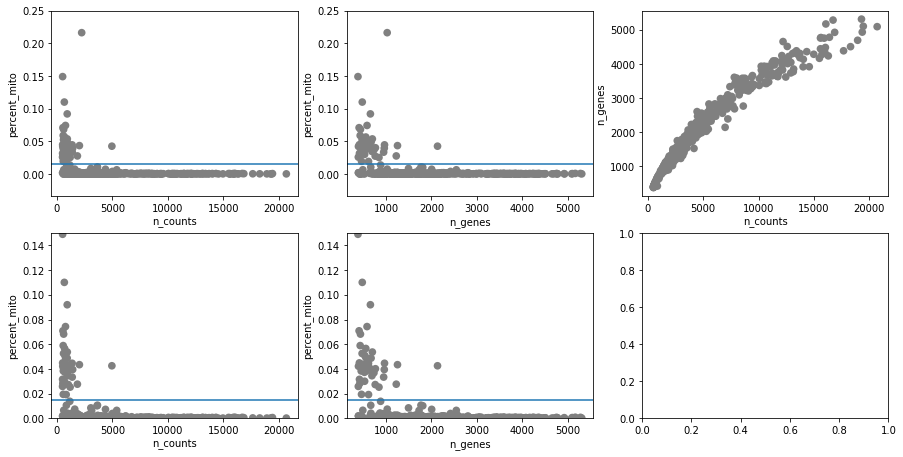

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7.5))

# Global view
sc.pl.scatter(data, x='n_counts', y='percent_mito', show=False, ax=axs[0, 0])
sc.pl.scatter(data, x='n_genes', y='percent_mito', show=False, ax=axs[0, 1]);
sc.pl.scatter(data, x='n_counts', y='n_genes', show=False, ax=axs[0, 2])

# Add a horizontal line at the mito percent cut-off
axs[0, 0].axhline(y=MITO_CUTOFF)
axs[0, 1].axhline(y=MITO_CUTOFF)

# Zoom in on cut-off
sc.pl.scatter(data, x='n_counts', y='percent_mito', show=False, ax=axs[1, 0])
sc.pl.scatter(data, x='n_genes', y='percent_mito', show=False, ax=axs[1, 1]);

axs[1, 0].set_ylim([0.0, 0.15])
axs[1, 1].set_ylim([0.0, 0.15])
# Add a horizontal line again
axs[1, 0].axhline(y=MITO_CUTOFF)
axs[1, 1].axhline(y=MITO_CUTOFF)

In [38]:
# How many cells do we classify as dying?
n_dying = np.sum(data.obs['percent_mito'] >= MITO_CUTOFF)
n_alive = np.sum(data.obs['percent_mito'] < MITO_CUTOFF)

print("Dying: {}\nAlive: {}".format(n_dying, n_alive))

Dying: 43
Alive: 465


In [39]:
# We remove cells that have a high fraction of mito genes, as that marks dead/dying cells.
data = data[data.obs['percent_mito'] < MITO_CUTOFF, :]

In [40]:
# Parsing transcription factor gene names from http://genome.gsc.riken.jp/TFdb/tf_list.html
def known_transcription_factors():
    infname = 'From_Sara/mm_transcription_factors-mm_tf_list.html'
    with open(infname) as infile:
        return set([line.split('<td')[3][1:-5] for line in infile if line.startswith('<tr>')])
    
TFs = known_transcription_factors()
transfac_genes = [name for name in data.var_names if name in TFs]

In [41]:
# And which are the most expressed transcription factors?
top = 30

#maxs = data[:, transfac_genes].X.max(axis=0).toarray()[0] (#commented out in Sara's)
maxs = data[:, transfac_genes].X.sum(axis=0)
indices = np.argpartition(maxs, kth=len(maxs)-top)[-top:]
most_expressed_tfs = data[:, transfac_genes].var_names[indices].sort_values().tolist()
most_expressed_tfs

[['1700003F12Rik',
  '1700020N01Rik',
  '1700086D15Rik',
  '2410141K09Rik',
  '2810021J22Rik',
  '3632451O06Rik',
  '4930430A15Rik',
  '4930522L14Rik',
  '4931423N10Rik',
  '4933429H19Rik',
  '6720489N17Rik',
  '9130019O22Rik',
  'A030003K21Rik',
  'A630089N07Rik',
  'Aatf',
  'Abt1',
  'Abtb1',
  'Acyp2',
  'Adnp',
  'Aebp1',
  'Aebp2',
  'Aes',
  'Ahr',
  'Ahrr',
  'Aip',
  'Aire',
  'Alx3',
  'Alx4',
  'Ank1',
  'Ank2',
  'Ankfy1',
  'Ankhd1',
  'Ankra2',
  'Ankrd1',
  'Ankrd10',
  'Ankrd2',
  'Ankrd6',
  'Ar',
  'Arhgap17',
  'Arid1a',
  'Arid3a',
  'Arid3b',
  'Arid4a',
  'Arid5b',
  'Arnt',
  'Arnt2',
  'Arntl',
  'Arx',
  'Asb1',
  'Asb10',
  'Asb11',
  'Asb12',
  'Asb15',
  'Asb2',
  'Asb3',
  'Asb4',
  'Asb5',
  'Asb6',
  'Asb8',
  'Asb9',
  'Ascl1',
  'Ascl2',
  'Ascl3',
  'Ash1l',
  'Ash2l',
  'Asxl1',
  'Atf1',
  'Atf2',
  'Atf3',
  'Atf4',
  'Atf5',
  'Atf6',
  'Atf7',
  'Atf7ip',
  'Atm',
  'Atoh1',
  'BC024063',
  'BC024139',
  'Bach1',
  'Bach2',
  'Bard1',
  'Barhl1',


In [42]:
data = normalize(data)

//anaconda3/envs/bigData/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


extracting highly variable genes
    Gene indices [18909, 30265] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:07)


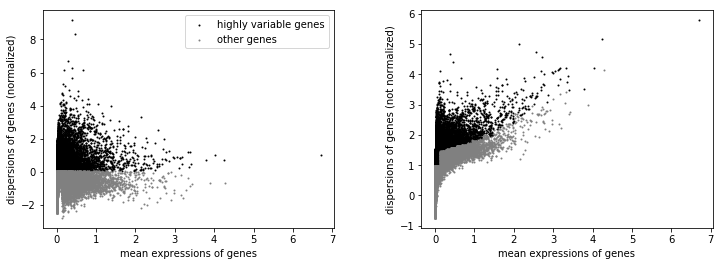

In [43]:
n_bins = 50
result = filter_by_expr_dispersion(data, n_bins, dry_run=True)

In [44]:
data = filter_by_expr_dispersion(data, n_bins, dry_run=False)

extracting highly variable genes
    Gene indices [18909, 30265] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)


//anaconda3/envs/bigData/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:
//anaconda3/envs/bigData/lib/python3.7/site-packages/scanpy/_utils.py:342: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:
//anaconda3/envs/bigData/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [45]:
# data = regress_and_scale(data)
sc.pp.scale(data)

    ... scale_data: as `zero_center=True`, sparse input is densified and may lead to large memory consumption.


//anaconda3/envs/bigData/lib/python3.7/site-packages/scanpy/_utils.py:342: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:


computing PCA with n_comps = 30
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


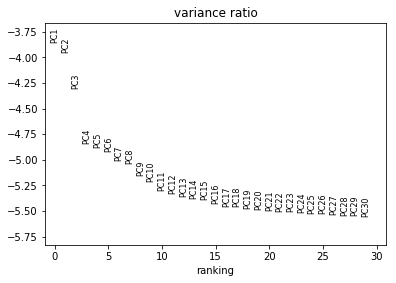

In [46]:
sc.tl.pca(data, svd_solver='arpack', n_comps=30)
sc.pl.pca_variance_ratio(data, log=True, save=True)



## Clustering/tSNE from Act-Seq document 

computing PCA with n_comps = 30
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


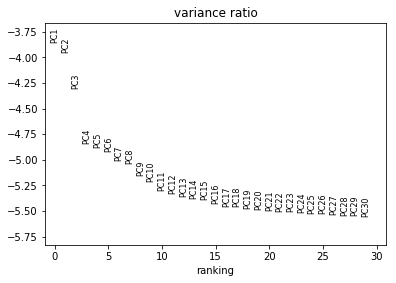

In [47]:
sc.tl.pca(data, n_comps=30, svd_solver='arpack')
sc.pl.pca_variance_ratio(data, log=True, save=True)

In [239]:
def color_in_PCA(adata,color_parameter):
    sc.pl.pca(adata, color=color_parameter)

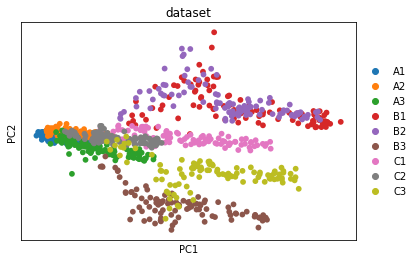

In [241]:
color_in_PCA(data,'dataset')

In [48]:
pcs_used = 18


In [49]:
def plot_graph(data, seed, dotsize, ax):
    """
    Spring-based projection with pretty colouring of the Louvain clusters.
    """
    # Set nice colours
    data.uns['louvain_colors'] = [mpcol.to_hex(c) for c in sns.color_palette(
        "hls", len(data.obs['louvain'].cat.categories))]
    
    # Prepare plot if we did not get one
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.get_figure()
    
    # Fill in a default value
    if not dotsize:
        dotsize = 12
    
    # Plot
    sc.tl.draw_graph(data, random_state=seed)
    sc.pl.draw_graph(data, color='louvain', size=dotsize, 
        title='Spring-based projection', legend_loc='on data', show=False, ax=ax)
    return data, fig, ax

def plot_umap(data, seed, dotsize, ax):
    """
    UMAP projection and pretty colouring of the Louvain clusters.
    """
    # Colours
    data.uns['louvain_colors'] = [mpcol.to_hex(c) for c in sns.color_palette(
        "hls", len(data.obs['louvain'].cat.categories))]
    
    # Prepare plot if we did not get one
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.get_figure()    
    
    # Fill in a default value
    if not dotsize:
        dotsize = 12
    
    # Plot
    sc.tl.umap(data, random_state=seed)
    sc.pl.umap(data, color='louvain', size=dotsize, 
        title='UMAP projection', legend_loc='on data', show=False, ax=ax)
    return data, fig, ax

def plot_tsne(data, pcs_used, seed, dotsize, ax):
    """
    tSNE projection and colouring of Louvain clusters.
    """
    # Colours
    data.uns['louvain_colors'] = [mpcol.to_hex(c) for c in sns.color_palette(
        "hls", len(data.obs['louvain'].cat.categories))]

    # Prepare plot if we did not get one
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    else:
        fig = ax.get_figure()
    
    # Fill in a default value
    if not dotsize:
        dotsize = 12
    
    # Plot
    sc.tl.tsne(data, n_pcs=pcs_used, random_state=seed)
    sc.pl.tsne(data, color='louvain', size=dotsize,
        legend_loc='on data', title='tSNE projection', show=False, ax=ax)
    return data, fig, ax

In [50]:
def cluster_and_plot(data):

    nbs = 25
    sc.pp.neighbors(data, n_pcs=pcs_used, n_neighbors=nbs)
    sc.tl.louvain(data)

#Prepare a figure to show three 2D projections of the cells and colour them by Louvain communities (=clusters). 
#Be careful interpreting the tSNE projection, see <https://distill.pub/2016/misread-tsne/>. Also, note that the `seed` and `dotsize` variables are re-used in all three plots.

    seed = 18
    dotsize = 12

    fig, axes = plt.subplots(1, 3, figsize=(15, 5.02))

# Plot the "classical" tSNE projection
    _ = plot_tsne(data, pcs_used, seed, dotsize, axes[0])

# Plot the UMAP projection, which maintains the distances between clusters better than tSNE
    _ = plot_umap(data, seed, dotsize, axes[1])

# Plot a spring-based projection, a classical algorithm to project graphs onto 2D
    _ = plot_graph(data, seed, dotsize, axes[2])

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 18
    computed neighbors (0:00:00)


//anaconda3/envs/bigData/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    computed connectivities (0:00:05)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 18
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:02)
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
drawing single-cell graph using layout 'fa'
   

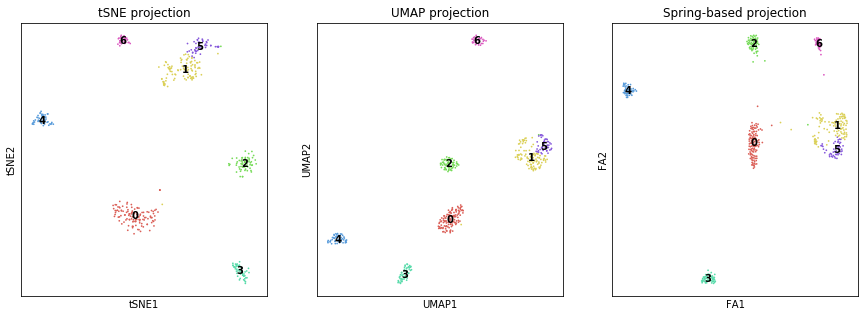

In [51]:
cluster_and_plot(data)

### Trying to color by cluster

In [237]:
def color_umap_and_tsne(adata,color_parameter):
    sc.pl.umap(adata, color=color_parameter)
    sc.pl.tsne(adata, color=color_parameter)

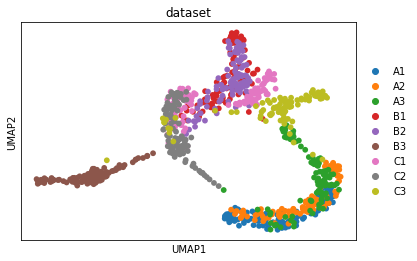

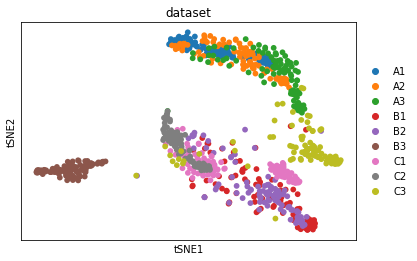

In [238]:
color_umap_and_tsne(data,'dataset')

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 18
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


//anaconda3/envs/bigData/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:02)


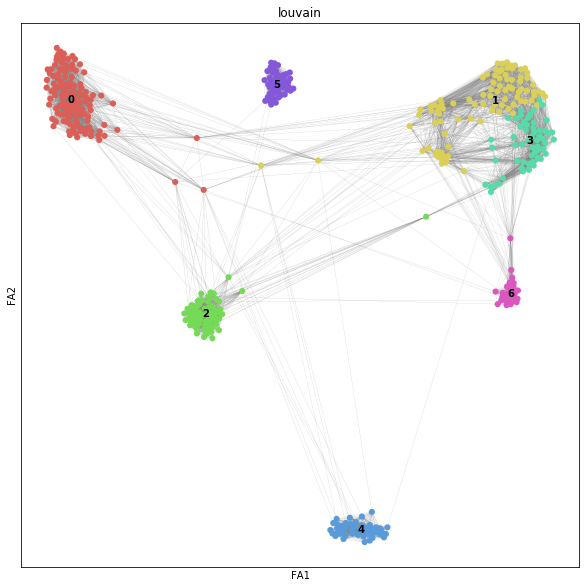

In [263]:
pcs_used, nbs, seed = 18, 30, 6
data, fig, ax = calc_and_plot_graph(data, pcs_used, nbs, seed);
fig.savefig('./figures/pca_clustering.png')

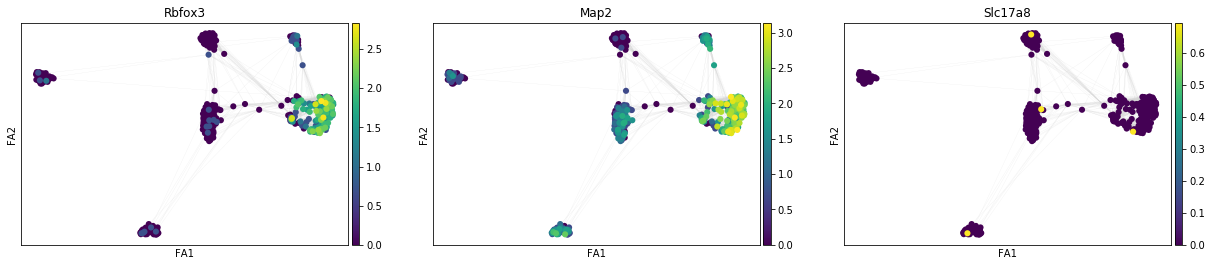

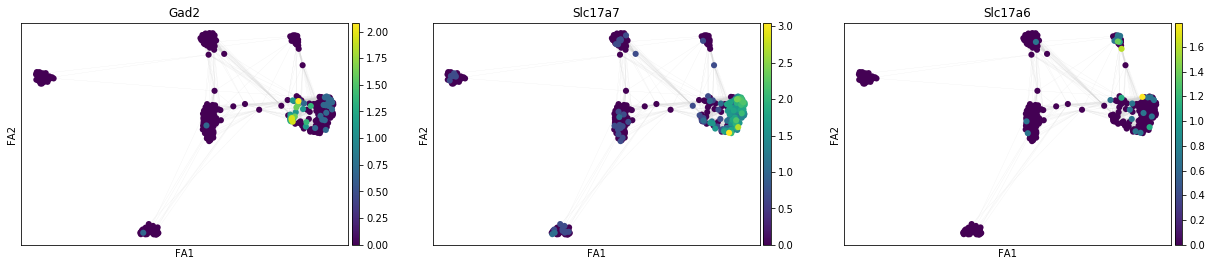

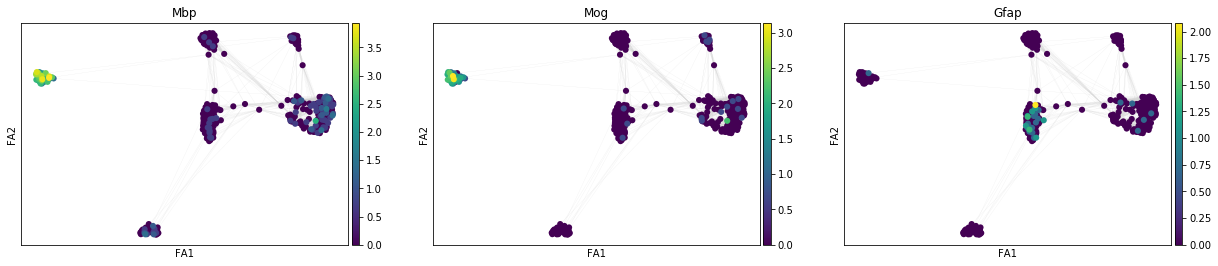

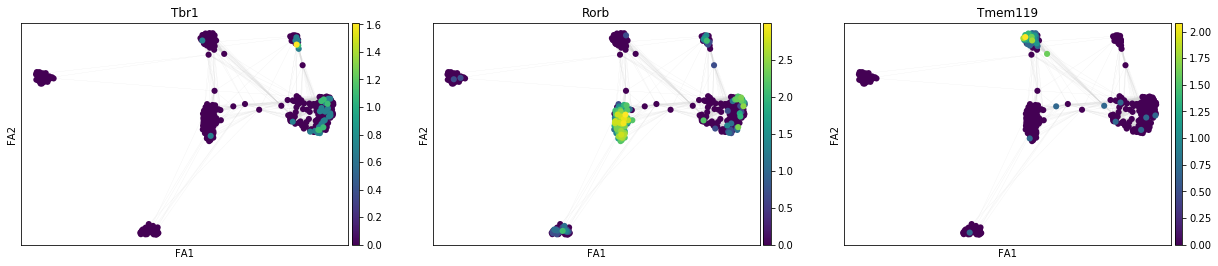

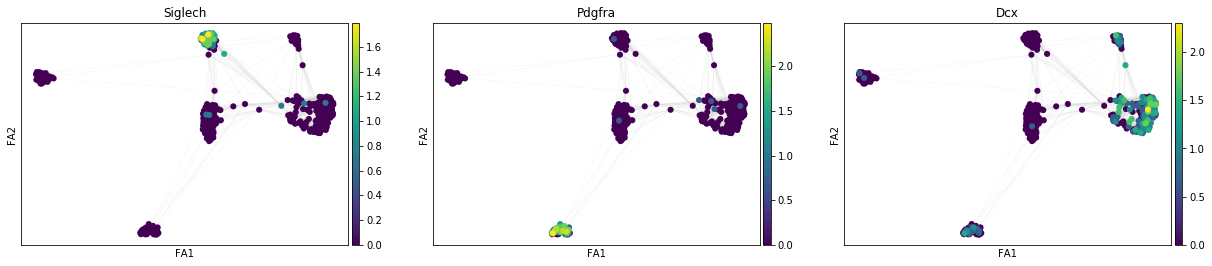

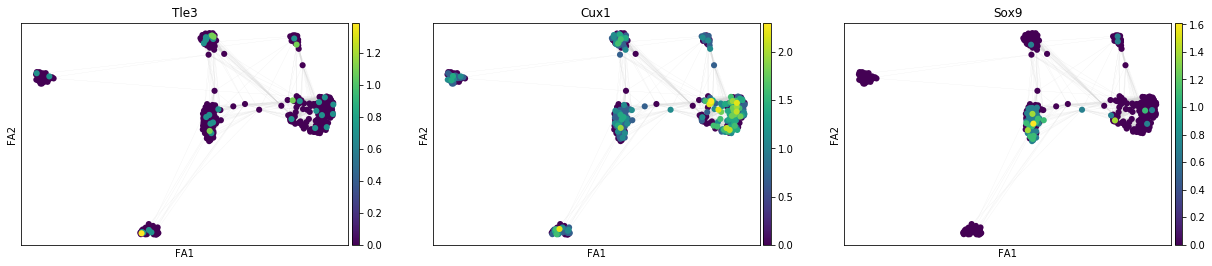

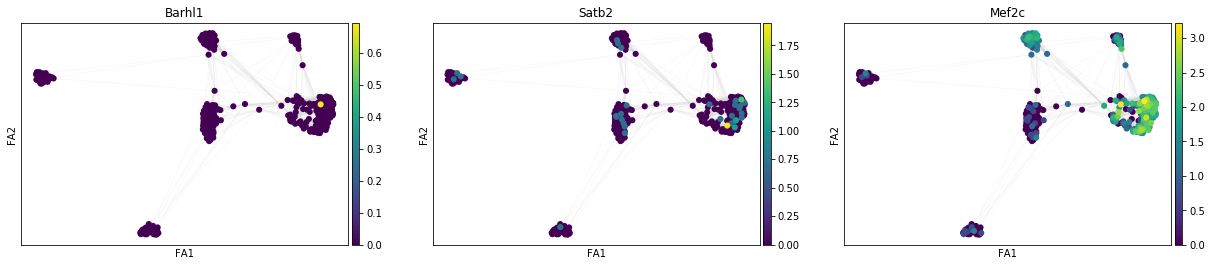

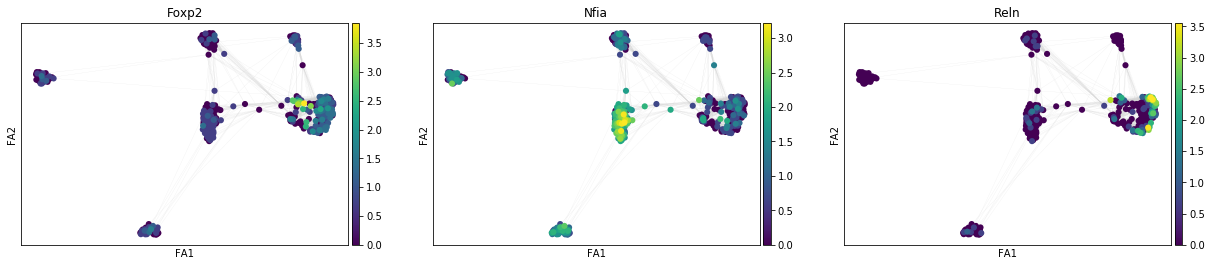

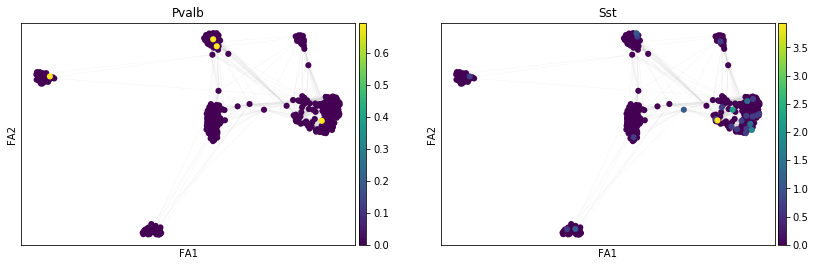

Not present: ['Syn', 'Tbr2', 'Blc11a', 'Blc11b', 'Couptf1', 'fezf2']


In [52]:
#Looking at main cell types markers and PCX layers markers
plot_expression_on_graph(data, 
    ['Rbfox3', 'Map2', 'Slc17a8','Gad2','Slc17a7','Slc17a6', 'Mbp', 'Mog', 'Gfap', 'Syn', 'Tbr2', 'Tbr1', 'Rorb', 'Tmem119', 'Siglech', 'Pdgfra','Dcx', 'Blc11a', 'Blc11b', 'Tle3', 'Cux1' , 'Sox9', 'Barhl1', 'Satb2', 'Mef2c','Foxp2', 'Nfia', 'Couptf1' , 'Reln','Pvalb', 'Sst', 'fezf2'  ], columns=3)

In [ ]:
data.obs['louvain'].cat.categories = [
    "0:astrocytes", "1:EN", "2:microglia", 
    "3:OPC", "4:Oligo", "5:IN", "6:progenitors"]

//anaconda3/envs/bigData/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 0 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
//anaconda3/envs/bigData/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 1 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
//anaconda3/envs/bigData/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 2 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
//anaconda3/envs/bigData/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 3 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance
//anaconda3/envs/bigData/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:939: RuntimeWarning: Glyph 4 missing from current font.
  s, flags=LOAD_NO_SCALE | LOAD_NO_HINTING).horiAdvance


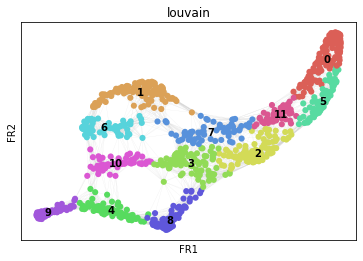

AnnData object with n_obs × n_vars = 900 × 30438 
    obs: 'batch', 'dataset', 'percent_mito', 'n_counts', 'n_genes', 'louvain'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'louvain', 'louvain_colors', 'draw_graph'
    obsm: 'X_pca', 'X_draw_graph_fr'
    varm: 'PCs'

In [191]:
plot_louvain_clusters(data)

In [266]:
sc.tl.rank_genes_groups(sim_data, 'louvain')
pd.DataFrame(sim_data.uns['rank_genes_groups']['names']).head(30)

ranking genes
    consider 'louvain' groups:
    with sizes: [161 149 138 115 114  93  74  56]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


0                   1                   2  \
0   ENSMUST00000089297            Slc1a2-1                Tcf7   
1   ENSMUST00000163463              Atp1a2              Glul-4   
2                Nptxr  ENSMUST00000111211                Hopx   
3             Atp1a3-1             mt-Rnr1  ENSMUST00000037712   
4               Spock2             mt-Rnr2  ENSMUST00000163477   
..                 ...                 ...                 ...   
25            Arhgap32            Slc1a3-1            Tmbim1-6   
26  ENSMUST00000033484             Fam107a            Phyhd1-9   
27            Snap25-1  ENSMUST00000163700             Dab2-13   
28                Napb                Dio2            Ptpn11-3   
29              Stxbp1             Aldoc-1  ENSMUST00000078392   

                     3                   4        5                   6  \
0                Apc-8              Mbp-10     Cdr1             Entr1-4   
1               Dbpht2              Mbp-14  Olfm1-2             Gm14739   
2              Gm42669              Mbp-11  Olfm1-4            Filip1-2   
3               Pter-2              Mbp-15   Snap25             Idh3g-5   
4               Meg3-5               Mbp-1      ND2           Pip4k2b-1   
..                 ...                 ...      ...                 ...   
25              Lrriq1               Kif5c     Nptn  ENSMUST00000109240   
26  ENSMUST00000027899  ENSMUST00000033801      Mmd             Olfr539   
27           Slc35e2-3              Syt1-1   Tmsb4x  ENSMUST00000093438   
28              Tut4-2              Mobp-3     Syn1               Pank2   
29            Gpr155-2                Arf3   Rtn4-2             Ddx20-1   

                     7  
0   ENSMUST00000089297  
1              Nptxr-1  
2                Nptxr  
3   ENSMUST00000163463  
4               Atp1a3  
..                 ...  
25              Cyfip2  
26             Olfm1-3  
27              Spock2  
28             Scn2a-1  
29             Ndrg4-2  

[30 rows x 8 columns]

In [138]:
sc.tl.rank_genes_groups(sim_data, 'dataset')
sim_markers_dataset = pd.DataFrame(sim_data.uns['rank_genes_groups']['names']).head(30)
sim_markers_dataset_scores = pd.DataFrame(sim_data.uns['rank_genes_groups']['scores']).head(30)

sim_markers_dataset.columns = ['simA1','simA2','simA3','simB1','simB2','simB3','simC1','simC2','simC3']
sim_markers_dataset_scores.columns = ['simA1','simA2','simA3','simB1','simB2','simB3','simC1','simC2','simC3']

sim_markers_dataset.to_csv('simulated_pirifrom_nuclei_marker_genes_by_dataset.csv')
sim_markers_dataset_scores.to_csv('simulated_pirifrom_nuclei_marker_genes_by_dataset_scores.csv')


sim_markers_dataset

ranking genes
    consider 'dataset' groups:
    with sizes: [100 100 100 100 100 100 100 100 100]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


simA1               simA2               simA3  \
0                 CYTB  ENSMUST00000111211             Ptgds-2   
1                  ND2            Slc1a2-1               Ptgds   
2   ENSMUST00000115856                Scd2             Ptgds-4   
3                  ND4              Slc1a2             Ptgds-1   
4              Sparcl1            Slc1a2-3             Ptgds-3   
5             Slc1a2-1             mt-Rnr2              Apoe-4   
6                  ND5            Slc1a2-2              Atp1a2   
7                 COX1             Ndrg2-1                Apoe   
8                 Car2                Glul              Apoe-5   
9   ENSMUST00000111211               Plpp3             Aldoc-1   
10             mt-Rnr1                  Qk                Apod   
11                Dio2           Slc1a2-11             Sparcl1   
12  ENSMUST00000108591             Aldoc-3              Apoe-8   
13                 Cpe            Slc1a2-8               Timp3   
14               Prex2               Paqr8  ENSMUST00000115856   
15               mt-Tv            Slc1a3-1              Igf2-3   
16                Aqp4               Aldoc               Ndrg2   
17             mt-Rnr2              Slc1a3              Slc1a3   
18              Camk2a            Tulp4-11             mt-Rnr1   
19             Mertk-1                COX1                Cst3   
20             Slc7a11            Atp1a2-2  ENSMUST00000053222   
21           Fam107a-2                Ncs1            Camk2a-1   
22              Myo6-3             Tulp4-9                Aqp4   
23  ENSMUST00000113259               Clu-1  ENSMUST00000174784   
24              Rorb-2               Gna13              Slc2a1   
25                Nfia                Gfap               Aldoc   
26             Ttyh1-2  ENSMUST00000109959            Slc1a2-1   
27  ENSMUST00000086397                Gja1               Neat1   
28              Nfia-2               Sfxn5              Syn3-2   
29               Mertk              Lrrc58  ENSMUST00000111211   

                 simB1               simB2               simB3  \
0               Lmo3-3  ENSMUST00000163463             Olfm1-4   
1   ENSMUST00000175336               Nptxr                Cdr1   
2   ENSMUST00000170784  ENSMUST00000089297             Olfm1-2   
3               Lmo3-5              Meg3-8               Vsnl1   
4                 Chn1             Nptxr-1                 ND2   
5   ENSMUST00000163463              Snhg11                Mdh1   
6             Atp2b2-2             Cacna1e  ENSMUST00000161001   
7               Lmo3-6               Scn2a                 Mmd   
8              Nptxr-1              Malat1            Tmsb4x-2   
9               Atp2b2              Ncdn-2                Nptn   
10  ENSMUST00000023462  ENSMUST00000159992              Snap25   
11              Rbfox1              Unc13a              Rtn4-1   
12           Arpp21-29               Map1a                Rtn4   
13               Nptxr              Atp1a3                 ND6   
14           Arpp21-21             Grin1-6              Atp1b1   
15            Pafah1b2  ENSMUST00000170784              Atp5a1   
16              Rtn1-2                Npcd              Syn1-1   
17  ENSMUST00000088752  ENSMUST00000163124                Snca   
18             Rab3a-2               Pgbd5              Tubb2a   
19                Lmo3             Pgbd5-5              Rtn4-3   
20            Stxbp1-2            Adgrb2-6                Chgb   
21              Stxbp1  ENSMUST00000074924               Basp1   
22  ENSMUST00000089297             Pcdh1-3              Nptn-1   
23             Nrxn3-7              Spock2                Rtn1   
24  ENSMUST00000101331               Tiam1              Rtn1-4   
25  ENSMUST00000067437  ENSMUST00000175336  ENSMUST00000166486   
26              Ncdn-1  ENSMUST00000066644              Snca-1   
27           Arhgef9-4           Arpp21-13            Atp5a1-1   
28                Arf3  ENSMUST00000171354            At

In [137]:
sc.tl.rank_genes_groups(data, 'louvain')
sndata_markers = pd.DataFrame(data.uns['rank_genes_groups']['names']).head(30)
sndata_markers_scores = pd.DataFrame(data.uns['rank_genes_groups']['scores']).head(30)

sndata_markers.columns = ['sn0','sn1','sn2','sn3','sn4','sn5','sn6']
sndata_markers_scores.columns = ['sn0','sn1','sn2','sn3','sn4','sn5','sn6']

sndata_markers.to_csv('piform_snRNA-Seq_marker_genes.csv')
sndata_markers
sndata_markers_scores.to_csv('piform_snRNA-Seq_marker_genes_scores.csv')



ranking genes
    consider 'louvain' groups:
    with sizes: [119 103  64  50  49  48  32]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [53]:
#sc.tl.rank_genes_groups(data, 'louvain', method='t-test')
sc.tl.rank_genes_groups(data, 'louvain', method='logreg')

ranking genes
    consider 'louvain' groups:
    with sizes: [119 103  64  50  49  48  32]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:04)


//anaconda3/envs/bigData/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


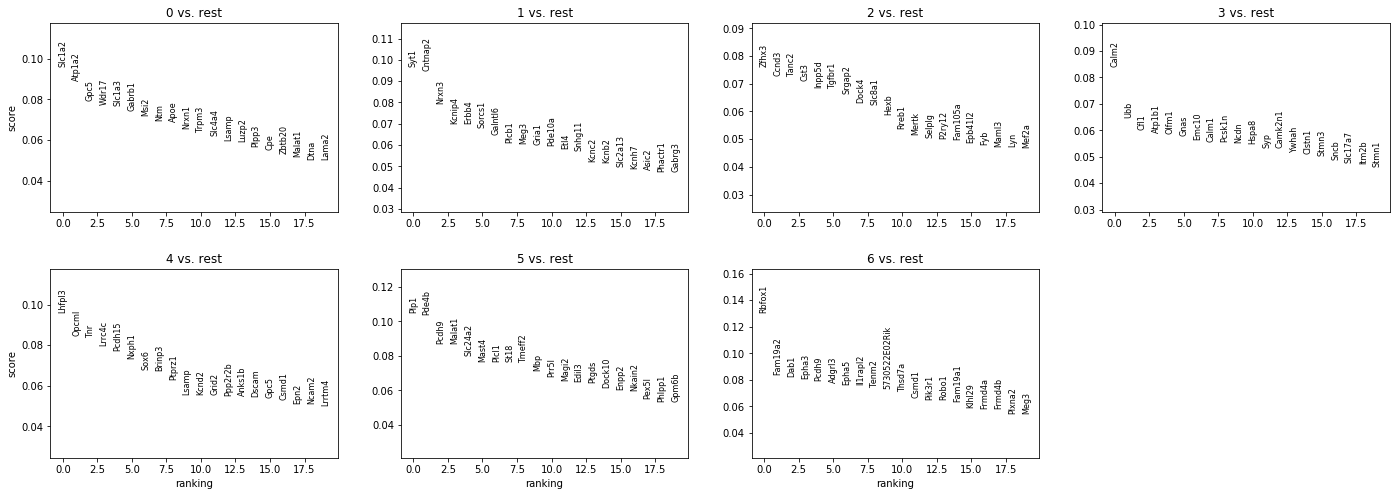

In [268]:
top = 20
sc.pl.rank_genes_groups(data, n_genes=top, sharey=False)

In [195]:
sc.tl.rank_genes_groups(data, 'louvain', n_genes=len(data.var_names))
neuron_ranking_genes = pd.DataFrame(data.uns['rank_genes_groups']['names'])[[
   "0:astrocytes", "1:EN", "2:microglia", 
    "3:OPC", "4:Oligo", "5:IN", "6:progenitors"]]

# Top transcription factors in different piriform neuronal clusters
top = 30
result = []
for colname, ranking in neuron_ranking_genes.iteritems():
    result.append(pd.Series([gname for gname in ranking if gname in transfac_genes]))
pd.concat(result, axis=1)[:top]

ranking genes
    consider 'louvain' groups:
    with sizes: [118 109  94  88  69  68  66  65  61  56  55  51]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


KeyError: "None of [Index(['0:astrocytes', '1:EN', '2:microglia', '3:OPC', '4:Oligo', '5:IN',\n       '6:progenitors'],\n      dtype='object')] are in the [columns]"

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_louvain']`


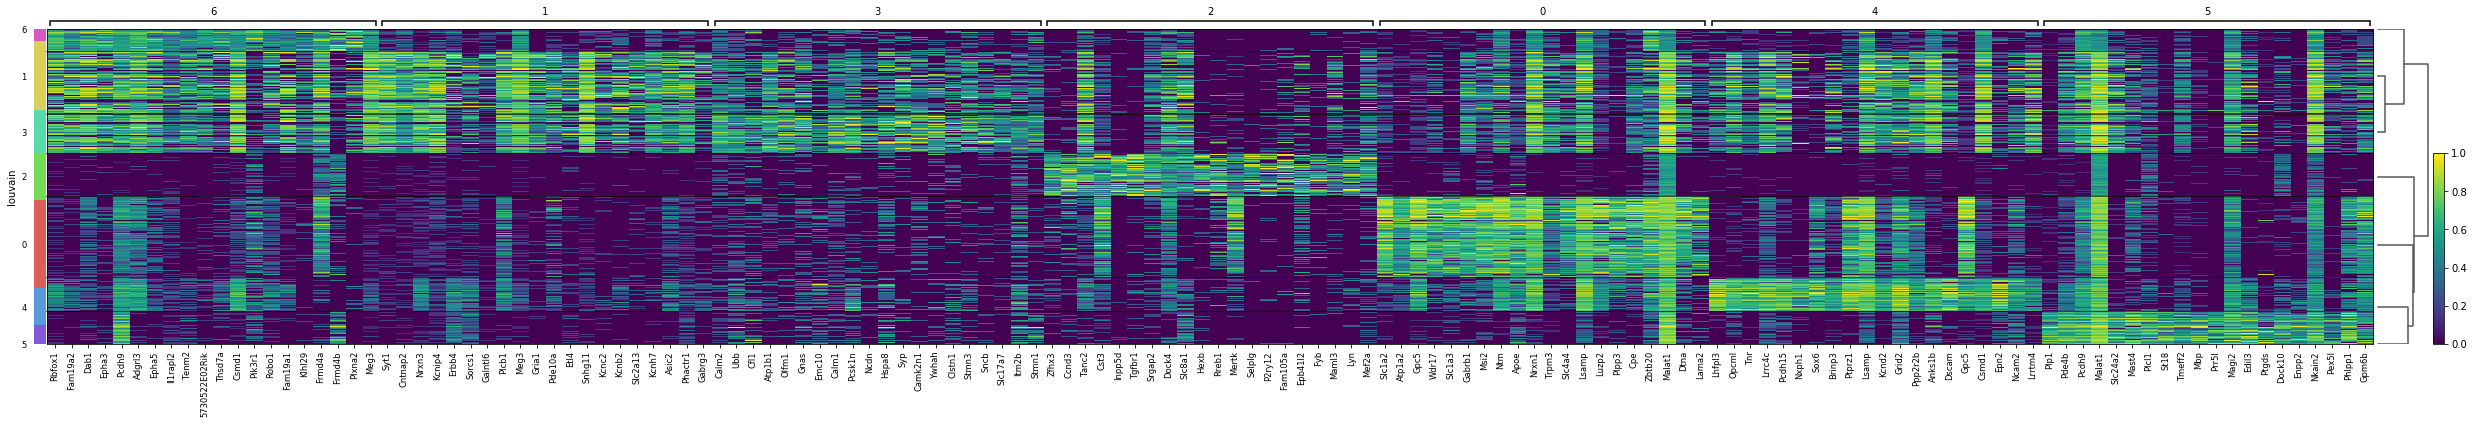

In [269]:
sc.pl.rank_genes_groups_heatmap(data, n_genes=20, standard_scale='var', show_gene_labels=True)

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_louvain']`


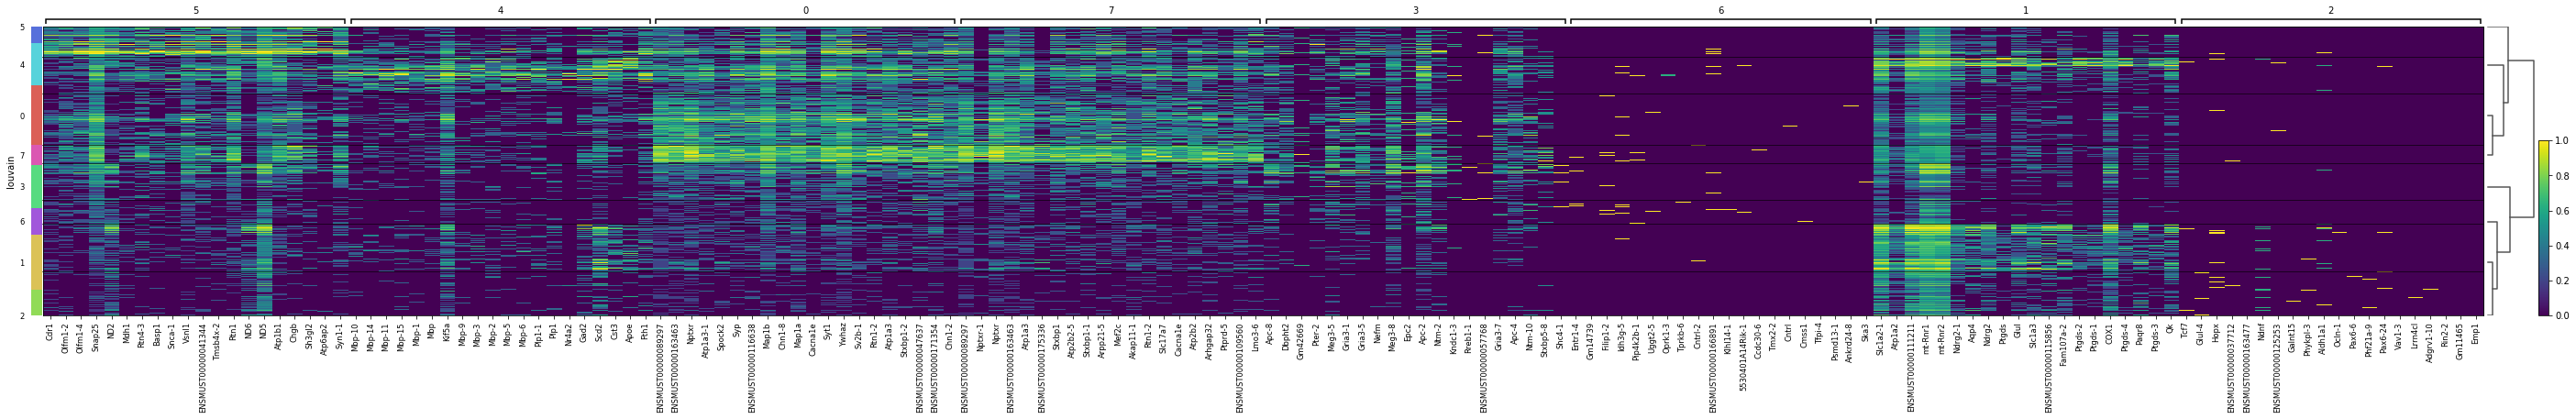

In [270]:
sc.pl.rank_genes_groups_heatmap(sim_data, n_genes=20, standard_scale='var', show_gene_labels=True)

In [ ]:
import numpy as np
ad = data.copy()
ad.raw.X.data = np.exp(ad.raw.X.data)

In [ ]:
ax = sc.pl.correlation_matrix(data, 'louvain')

In [ ]:
marker_genes = ['Gfap','Rbfox3','Gad2','Slc17a7','Tmem119', 'Pdgfra', 'Mbp', 'Mog']

In [ ]:
ad = data.copy()
ad.raw.X.data = np.exp(ad.raw.X.data)

In [ ]:
ax = sc.pl.stacked_violin(data, marker_genes, groupby='louvain', swap_axes=True,
                         var_group_positions=[(7, 8)], var_group_labels=['neurons'], dendrogram=True)

# Making Similarity Matrix

### (back to writing original code)

In [83]:
#takes in list of tuples of dataframes, ex. [(names_df, scores_df)]
def make_dataframe_for_similarity_matrix(list_of_datasets): 
    #first make outline of dataframe, then will fill with values
    list_of_cluster_names = []
    gene_list = []
    for names, scores in list_of_datasets:
        list_of_cluster_names = list_of_cluster_names + list(names.columns)
        for row_list in names.values.tolist(): #returns dataframe as list of lists
            for gene_name in row_list:
                if gene_name not in gene_list:
                    gene_list.append(gene_name)
    #print(gene_list) #(good test)
    
    
    list_of_lists = []
    zero_list = [0] * len(gene_list)
    for i in range(0,len(list_of_cluster_names)):
        list_of_lists.append(zero_list)

    df = pd.DataFrame(list_of_lists, columns = gene_list, index = list_of_cluster_names)
    #print(df) #testing before filling
    
    #now that dataframe is generated, need to put in the values

    for names, scores in list_of_datasets:        
        for column_index in range(0,len(names.columns)):
            for row_index in range(0,len(names.index)):
                gene = names.iat[row_index,column_index]
                
                df.at[names.columns[column_index],gene] = scores.get_value(row_index,column_index,takeable = True)
            
    return df

In [77]:
def negate_e(x):
    y = 100-x
    return y

In [78]:
def negate_c(x):
    y = 1-x
    return y

In [79]:
def make_similarity_matrix_Euclidian(df):
    pairwise = pd.DataFrame(squareform(pdist(df)),columns = df.index, index = df.index)
    pairwise_negated = pairwise.applymap(negate_e)
    print(pairwise_negated)
    plt.figure(figsize=(10,10))
    sns.heatmap(pairwise_negated,cmap='OrRd',linewidth=1)

In [124]:
def make_similarity_matrix_cosine(df):
    pairwise = pd.DataFrame(squareform(pdist(df,metric = 'cosine')),columns = df.index, index = df.index)
    pairwise_negated = pairwise.applymap(negate_c)
    print(pairwise_negated)
    plt.figure(figsize=(10,10))
    sns.heatmap(pairwise_negated,cmap='OrRd',linewidth=1)

In [128]:
def make_similarity_matrix_cosine_mask_diagonal(df):
    pairwise = pd.DataFrame(squareform(pdist(df,metric = 'cosine')),columns = df.index, index = df.index)
    pairwise_negated = pairwise.applymap(negate_c)
    
    mask = np.zeros(pairwise_negated.shape, dtype=bool) 
    mask[np.triu_indices(len(mask))] = True
    plt.figure(figsize=(10,10))
    sns.heatmap(
        pairwise_negated,
        cmap='OrRd',
        linewidth=1,
        mask = mask,
        vmax = 0.4,
        vmin = 0
    )

In [57]:
make_similarity_matrix_Euclidian(df_for_matrix)

NameError: name 'df_for_matrix' is not defined

In [109]:
sndata_markers = pd.read_csv('piform_snRNA-Seq_marker_genes.csv')
sndata_markers_scores = pd.read_csv('piform_snRNA-Seq_marker_genes_scores.csv')

In [104]:
sc.tl.rank_genes_groups(sim_by_layer, 'layer')
sim_names_layer = pd.DataFrame(sim_by_layer.uns['rank_genes_groups']['names'])
sim_scores_layer = pd.DataFrame(sim_by_layer.uns['rank_genes_groups']['scores'])

In [110]:
#testing sim matrix
df_for_matrix = make_dataframe_for_similarity_matrix([(sndata_markers,sndata_markers_scores),(sim_names_layer,sim_scores_layer)])

//anaconda3/envs/bigData/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


            sn0       sn1  sn2  sn3       sn4       sn5       sn6     simA1  \
sn0    1.000000  0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.087460   
sn1    0.000000  1.000000  0.0  0.0  0.000000  0.096050  0.019196  0.000000   
sn2    0.000000  0.000000  1.0  0.0  0.000000  0.000000  0.000000  0.000000   
sn3    0.000000  0.000000  0.0  1.0  0.000000  0.000000  0.000000  0.000000   
sn4    0.000000  0.000000  0.0  0.0  1.000000  0.000000  0.000000  0.000000   
sn5    0.000000  0.096050  0.0  0.0  0.000000  1.000000  0.000000  0.028390   
sn6    0.000000  0.019196  0.0  0.0  0.000000  0.000000  1.000000  0.000000   
simA1  0.087460  0.000000  0.0  0.0  0.000000  0.028390  0.000000  1.000000   
simA2  0.195300  0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.163459   
simA3  0.161825  0.000000  0.0  0.0  0.034882  0.000000  0.000000  0.180104   
simB1  0.000000  0.000000  0.0  0.0  0.000000  0.064247  0.048935  0.000000   
simB2  0.000000  0.048381  0.0  0.0  0.000000  0.065

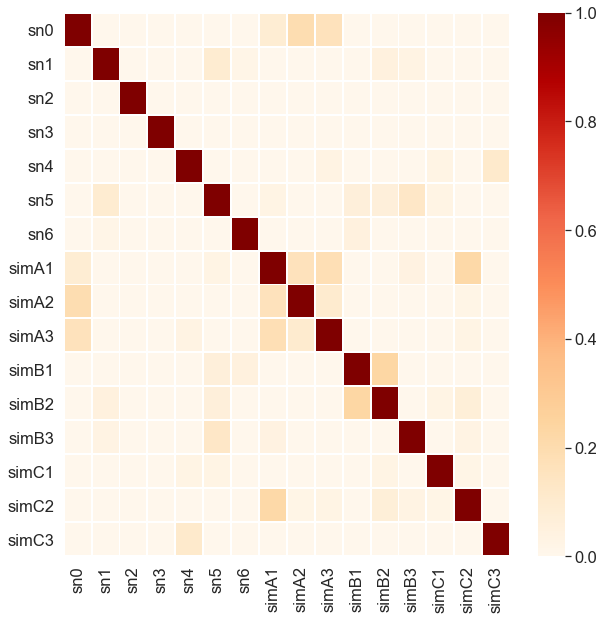

In [122]:
make_similarity_matrix_cosine(df_for_matrix)

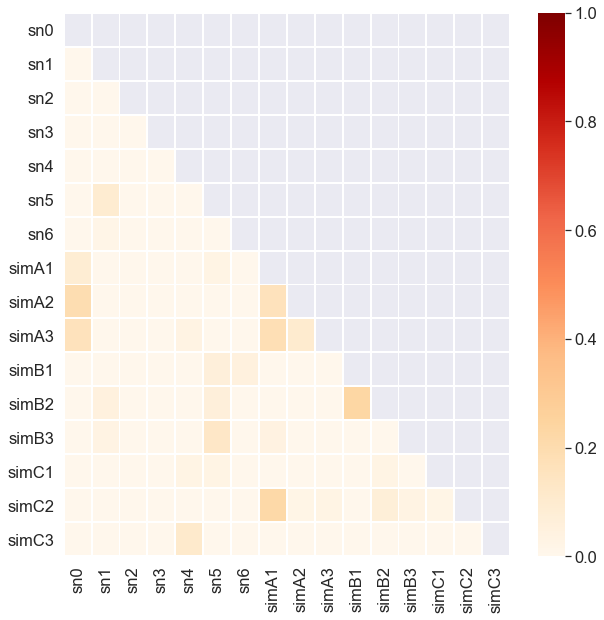

In [135]:
make_similarity_matrix_cosine_mask_diagonal(df_for_matrix)

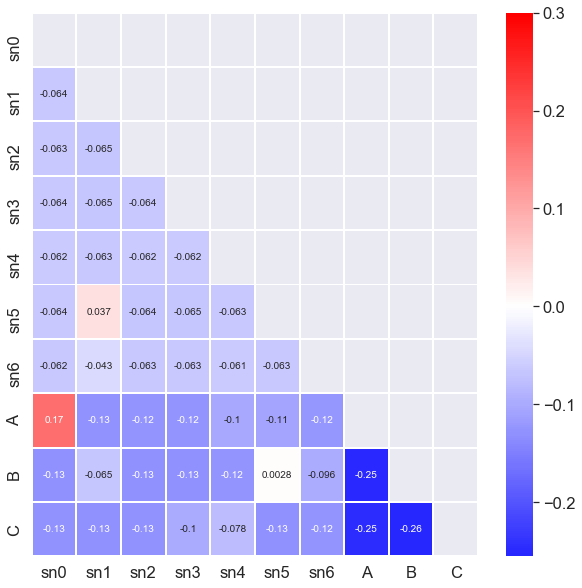

In [111]:
make_correlation_matrix(df_for_matrix)

## Testing pre-selected neurons vs. simulated nuclei considering all genes (reading in separately)

In [114]:
#reading in already generated nuclei from h5ad
simulated_nuclei = ad.read_h5ad('simulated_piriform_nuclei.h5ad')

In [115]:
sc.tl.rank_genes_groups(simulated_nuclei, 'dataset')
simulated_names_all = pd.DataFrame(simulated_nuclei.uns['rank_genes_groups']['names'])
simulated_names_all.to_csv('simulated_names_all.csv')

simulated_names_all.columns = ['sim A1','sim A2','sim A3','sim B1','sim B2','sim B3','sim C1','sim C2','sim C3']


In [116]:
sc.tl.rank_genes_groups(simulated_nuclei, 'dataset')
simulated_scores_all = pd.DataFrame(simulated_nuclei.uns['rank_genes_groups']['scores'])
simulated_scores_all.to_csv('simulated_scores_all.csv')

simulated_scores_all.columns = ['sim A1','sim A2','sim A3','sim B1','sim B2','sim B3','sim C1','sim C2','sim C3']



In [117]:
#reading in data
preselected_names_all = pd.read_csv('preselected_clustering_names_all.csv')
preselected_names_all.columns = ['seq 0','seq 1','seq 2','seq 3','seq 4']
preselected_scores_all = pd.read_csv('preselected_clustering_scores_all.csv')
preselected_scores_all.columns = ['seq 0','seq 1','seq 2','seq 3','seq 4']

In [118]:
#only considering top 30
#pre-selected snRNA-Seq
preselected_names_top = pd.read_csv('preselected_clustering_names_top.csv')
preselected_names_top.columns = ['seq 0','seq 1','seq 2','seq 3','seq 4']
preselected_scores_top = pd.read_csv('preselected_clustering_scores_top.csv')
preselected_scores_top.columns = ['seq 0','seq 1','seq 2','seq 3','seq 4']

#simulated
simulated_names_top = pd.read_csv('simulated_pirifrom_nuclei_marker_genes_by_dataset.csv')
simulated_names_top.columns = ['sim A1','sim A2','sim A3','sim B1','sim B2','sim B3','sim C1','sim C2','sim C3']
simulated_scores_top = pd.read_csv('simulated_pirifrom_nuclei_marker_genes_by_dataset_scores.csv')
simulated_scores_top.columns = ['sim A1','sim A2','sim A3','sim B1','sim B2','sim B3','sim C1','sim C2','sim C3']

In [119]:

matrix_df_all = make_dataframe_for_similarity_matrix([(simulated_names_all,simulated_scores_all),(preselected_names_all,preselected_scores_all)])

//anaconda3/envs/bigData/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [121]:
matrix_preselected_layer = make_dataframe_for_similarity_matrix([(preselected_names_all,preselected_scores_all),(sim_names_layer,sim_scores_layer)])

//anaconda3/envs/bigData/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [73]:
matrix_df_top = make_dataframe_for_similarity_matrix([(simulated_names_top,simulated_scores_top),(preselected_names_top,preselected_scores_top)])

//anaconda3/envs/bigData/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [107]:
def make_correlation_matrix(df):
    transposed_df = df.T
    corr = transposed_df.corr(method = "pearson")
    
    mask = np.zeros(corr.shape, dtype=bool) 
    mask[np.triu_indices(len(mask))] = True
    
    plt.figure(figsize=(10,10))
    sns.heatmap(corr,
                cmap='bwr',
                linewidth=1,
                #vmin = -0.1, #anchor the colormap
                center = 0,
                vmax = 0.3,  #anchor the colormap
                mask = mask,
                annot = True) #write value in the cell
    


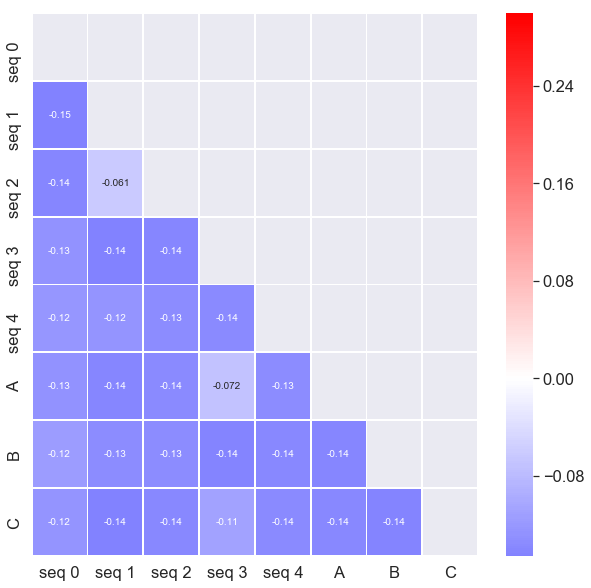

In [122]:
make_correlation_matrix(matrix_preselected_layer)

          seq 0     seq 1     seq 2     seq 3     seq 4         A         B  \
seq 0  1.000000  0.000000  0.000000  0.013220  0.012752  0.011464  0.026353   
seq 1  0.000000  1.000000  0.070672  0.000000  0.012886  0.000000  0.011235   
seq 2  0.000000  0.070672  1.000000  0.000000  0.000000  0.000000  0.006330   
seq 3  0.013220  0.000000  0.000000  1.000000  0.000000  0.058822  0.000000   
seq 4  0.012752  0.012886  0.000000  0.000000  1.000000  0.000000  0.000000   
A      0.011464  0.000000  0.000000  0.058822  0.000000  1.000000  0.000000   
B      0.026353  0.011235  0.006330  0.000000  0.000000  0.000000  1.000000   
C      0.017212  0.000000  0.000000  0.029770  0.000000  0.000000  0.000000   

              C  
seq 0  0.017212  
seq 1  0.000000  
seq 2  0.000000  
seq 3  0.029770  
seq 4  0.000000  
A      0.000000  
B      0.000000  
C      1.000000  


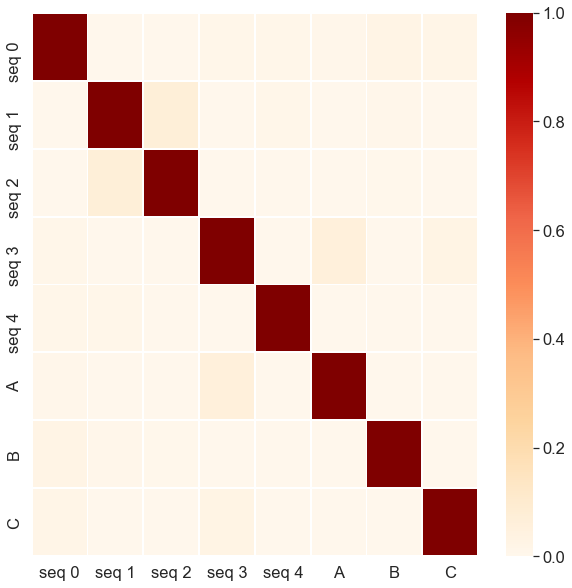

In [126]:
make_similarity_matrix_cosine(matrix_preselected_layer)

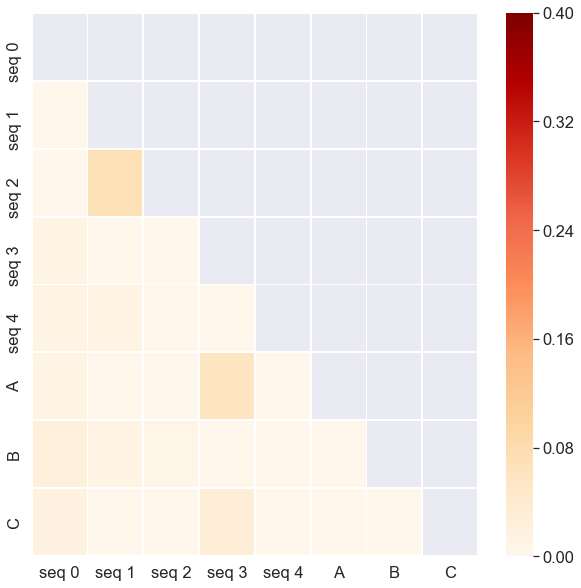

In [129]:
make_similarity_matrix_cosine_mask_diagonal(matrix_preselected_layer)

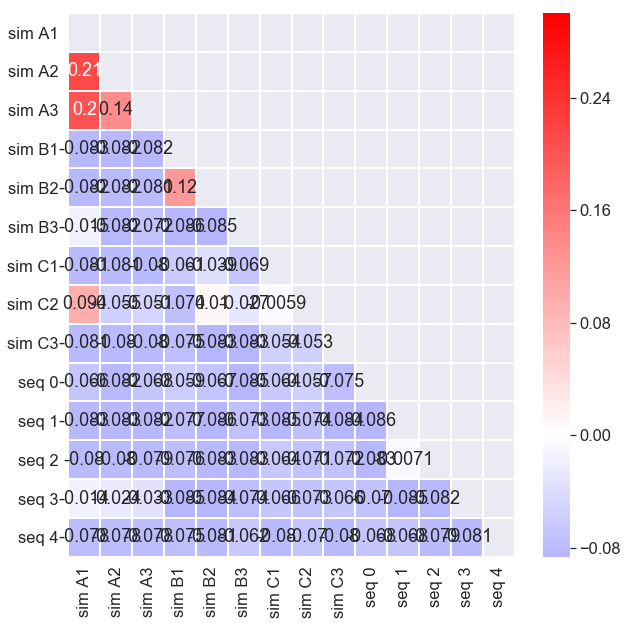

In [142]:
make_correlation_matrix(matrix_df_all)

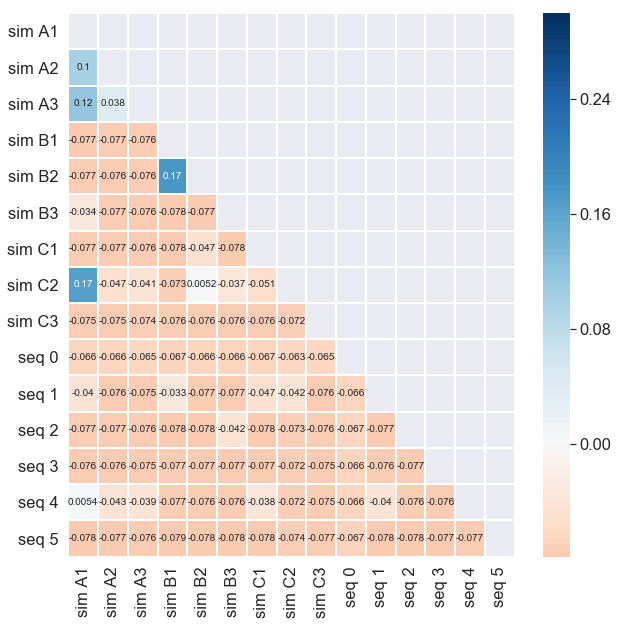

In [74]:
make_correlation_matrix(matrix_df_top)

                  A1        A2        A3        B1        B2        B3  \
A1          1.000000  0.271233  0.260551  0.000000  0.000000  0.061814   
A2          0.271233  1.000000  0.197947  0.000000  0.000000  0.000000   
A3          0.260551  0.197947  1.000000  0.000000  0.000000  0.008397   
B1          0.000000  0.000000  0.000000  1.000000  0.189518  0.000000   
B2          0.000000  0.000000  0.000000  0.189518  1.000000  0.000000   
B3          0.061814  0.000000  0.008397  0.000000  0.000000  1.000000   
C1          0.000000  0.000000  0.000000  0.021597  0.041559  0.013529   
C2          0.153755  0.014294  0.017874  0.000000  0.077505  0.042387   
C3          0.000000  0.000000  0.000000  0.007990  0.000000  0.000000   
Unnamed: 0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0:3         0.015395  0.000000  0.012409  0.024466  0.016814  0.000000   
1:2a/2b     0.000000  0.000000  0.000000  0.009271  0.000000  0.012196   
2:2a        0.000000  0.000000  0.0000

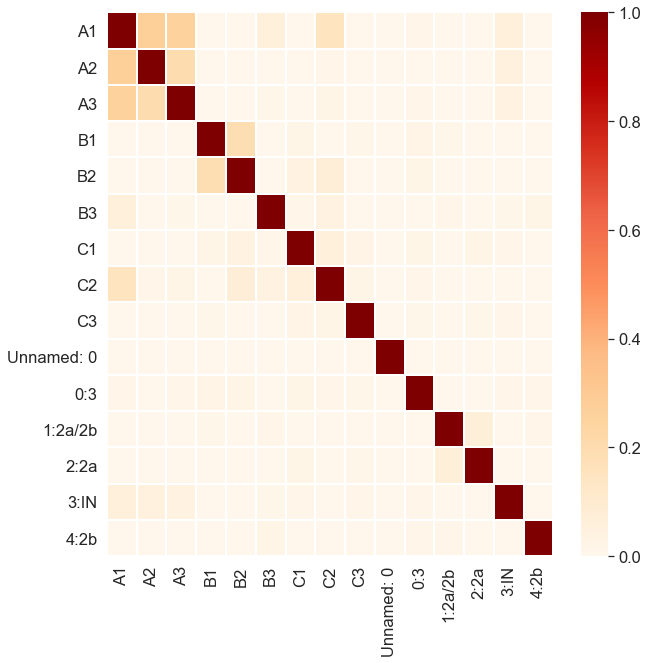

In [21]:
make_similarity_matrix_cosine(matrix_df_all)

# Trying removing top astrocyte genes from simulation

In [133]:
top_astro_and_oligo_genes = [line.rstrip('\n') for line in open('top_astrocytes_and_oligo_genes.txt')]
print(top_astro_and_oligo_genes)

['Atp1a2', 'Slc1a2', 'Slc1a3', 'Plpp3', 'Prex2', 'Msi2', 'Wdr17', 'Gpc5', 'Apoe', 'Phkg1', 'Sparcl1', 'Htra1', 'Gli3', 'Rorb', 'Ntsr2', 'Nhsl1', 'Sfxn5', 'Mfge8', 'Clu', 'F3', 'Pla2g7', 'Grm3', 'Luzp2', 'Nwd1', 'Bmpr1b', 'Mertk', 'Rgs20', 'Slco1c1', 'Bcan', 'Gja1', 'Plp1', 'St18', 'Mbp', 'Prr5l', 'Mog', 'Mobp', 'Enpp2', 'Cldn11', 'Plcl1', 'Dock10', 'Pde4b', 'Mag', 'Fa2h', '4-Sep', 'Edil3', 'Arhgap23', 'Sec14l5', 'Aspa', 'Phlpp1', 'St6galnac3', 'Rnf220', 'Ptgds', 'Slc24a2', 'Tmeff2', 'Mast4', 'Tubb4a', 'Ugt8a', 'Map7', 'Frmd5', 'Plekhh1']


In [159]:
#takes in list of tuples of dataframes, ex. [(names_df, scores_df)] and list_to_remove
#list_to_remove is the list of genes to remove
def make_dataframe_for_similarity_matrix_with_removal(list_of_datasets, list_to_remove): 
    #first make outline of dataframe, then will fill with values
    list_of_cluster_names = []
    gene_list = []
    for names, scores in list_of_datasets:
        list_of_cluster_names = list_of_cluster_names + list(names.columns)
        for row_list in names.values.tolist(): #returns dataframe as list of lists
            for gene_name in row_list:
                if gene_name not in gene_list:
                    gene_list.append(gene_name)
    #print(gene_list) #(good test)
    
    
    list_of_lists = []
    zero_list = [0] * len(gene_list)
    for i in range(0,len(list_of_cluster_names)):
        list_of_lists.append(zero_list)

    df = pd.DataFrame(list_of_lists, columns = gene_list, index = list_of_cluster_names)
    #print(df) #testing before filling
    
    #now that dataframe is generated, need to put in the values

    for names, scores in list_of_datasets:        
        for column_index in range(0,len(names.columns)):
            for row_index in range(0,len(names.index)):
                gene = names.iat[row_index,column_index]
                if gene in list_to_remove:
                    df.at[names.columns[column_index],gene] = 0
                else:
                    df.at[names.columns[column_index],gene] = scores.get_value(row_index,column_index,takeable = True)
            
    return df

### Top astrocty and oligo genes removed: Pre-selected snRNA-Seq, simulated by layer

In [160]:
astro_removed_preselected_layer = make_dataframe_for_similarity_matrix_with_removal([(preselected_names_all,preselected_scores_all),(sim_names_layer,sim_scores_layer)],top_astro_and_oligo_genes)

//anaconda3/envs/bigData/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


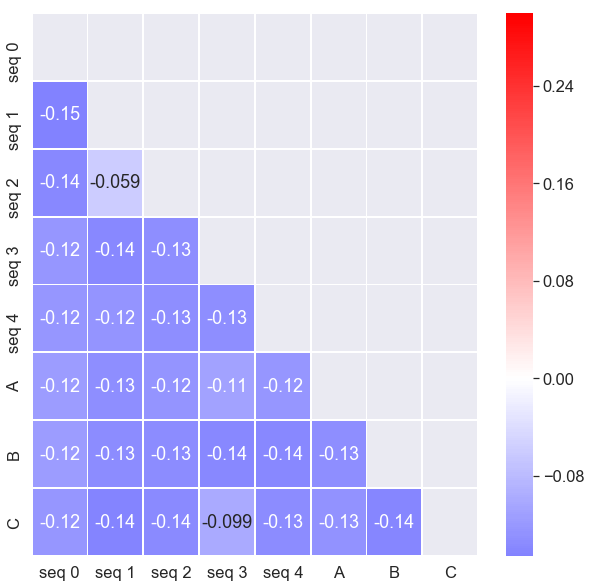

In [161]:
make_correlation_matrix(astro_removed_preselected_layer)

<Figure size 720x720 with 0 Axes>

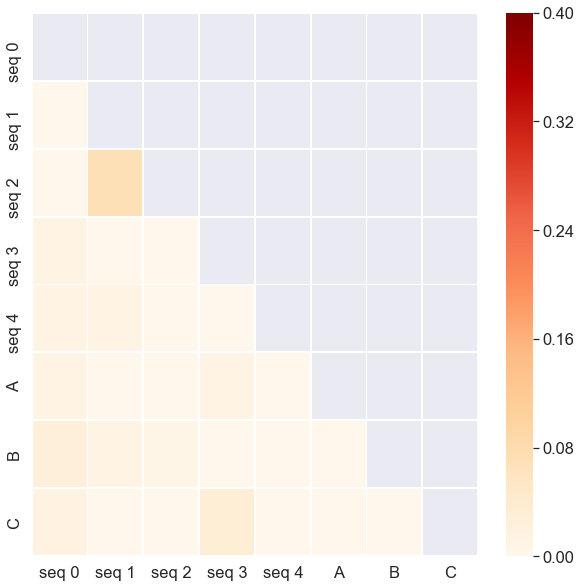

In [162]:
new_make_similarity_matrix_cosine(astro_removed_preselected_layer, True)

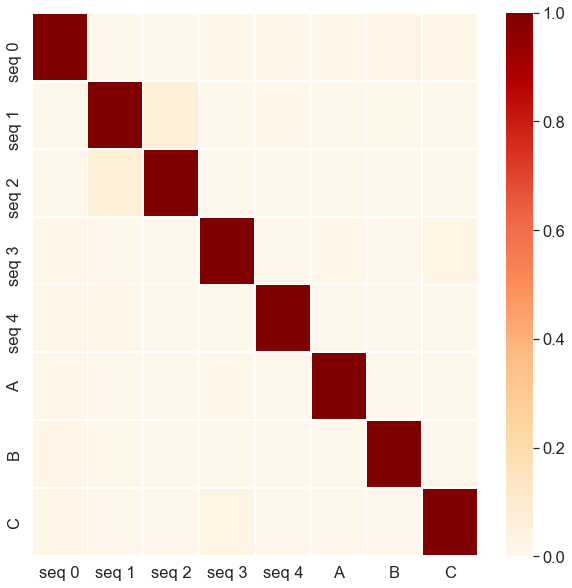

In [163]:
new_make_similarity_matrix_cosine(astro_removed_preselected_layer, False)

# Trying a new cosine similarity function

In [149]:
def new_make_similarity_matrix_cosine(df,mask_diagonal):
    cos_sim = pd.DataFrame(cosine_similarity(df,df),columns = df.index, index = df.index)
    
    #print(cos_sim)
    plt.figure(figsize=(10,10))
    if mask_diagonal == True:
        mask = np.zeros(cos_sim.shape, dtype=bool) 
        mask[np.triu_indices(len(mask))] = True
        plt.figure(figsize=(10,10))
        sns.heatmap(
            cos_sim,
            cmap='OrRd',
            linewidth=1,
            mask = mask,
            vmax = 0.4,
            vmin = 0
        )
    else:
        sns.heatmap(cos_sim,cmap='OrRd',linewidth=1)
        

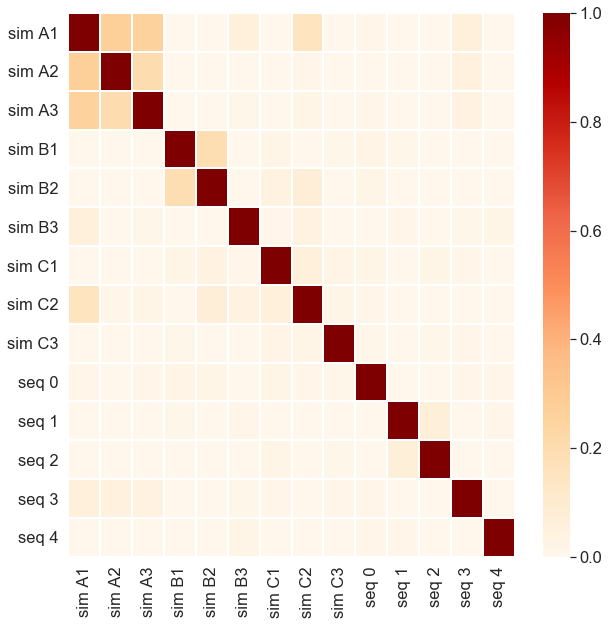

In [150]:
new_make_similarity_matrix_cosine(matrix_df_all, False)

<Figure size 720x720 with 0 Axes>

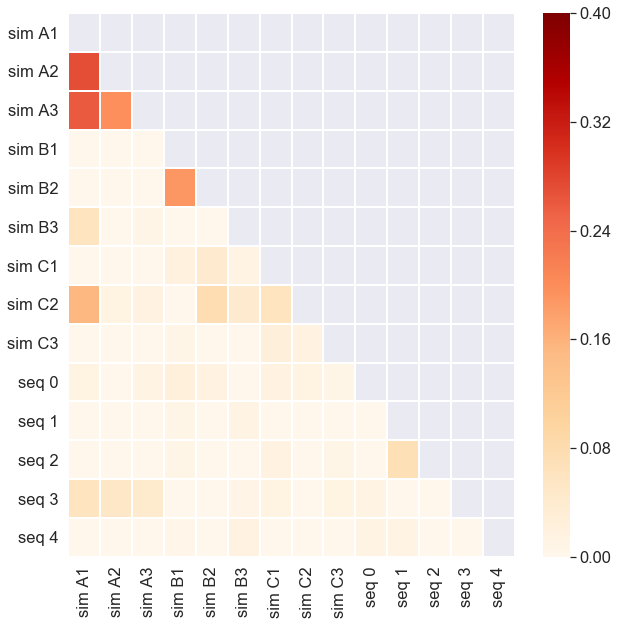

In [151]:
new_make_similarity_matrix_cosine(matrix_df_all, True)

# Trying dropping (code worked, strategy didn't)

In [71]:
sc.tl.rank_genes_groups(dropped_sim, 'dataset')
dropped_sim_names_dataset = pd.DataFrame(dropped_sim.uns['rank_genes_groups']['names'])
dropped_sim_scores_dataset = pd.DataFrame(dropped_sim.uns['rank_genes_groups']['scores'])

In [90]:
sc.tl.rank_genes_groups(dropped_sim, 'dataset')
dropped_sim_names_dataset_top = pd.DataFrame(dropped_sim.uns['rank_genes_groups']['names']).head(30)
dropped_sim_scores_dataset_top = pd.DataFrame(dropped_sim.uns['rank_genes_groups']['scores']).head(30)

In [74]:
sc.tl.rank_genes_groups(dropped_sim, 'layer')
dropped_sim_names_layer = pd.DataFrame(dropped_sim.uns['rank_genes_groups']['names'])
dropped_sim_scores_layer = pd.DataFrame(dropped_sim.uns['rank_genes_groups']['scores'])

In [91]:
sc.tl.rank_genes_groups(dropped_sim, 'layer')
dropped_sim_names_layer_top = pd.DataFrame(dropped_sim.uns['rank_genes_groups']['names']).head(30)
dropped_sim_scores_layer_top = pd.DataFrame(dropped_sim.uns['rank_genes_groups']['scores']).head(30)

In [87]:

matrix_df_dropped_dataset = make_dataframe_for_similarity_matrix([(dropped_sim_names_dataset,dropped_sim_scores_dataset),(preselected_names_all,preselected_scores_all)])

matrix_df_dropped_layer = make_dataframe_for_similarity_matrix([(dropped_sim_names_layer,dropped_sim_scores_layer),(preselected_names_all,preselected_scores_all)])



//anaconda3/envs/bigData/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [93]:
matrix_df_dropped_dataset_top = make_dataframe_for_similarity_matrix([(dropped_sim_names_dataset_top,dropped_sim_scores_dataset_top),(preselected_names_top,preselected_scores_top)])

matrix_df_dropped_layer_top = make_dataframe_for_similarity_matrix([(dropped_sim_names_layer_top,dropped_sim_scores_layer_top),(preselected_names_top,preselected_scores_top)])

//anaconda3/envs/bigData/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


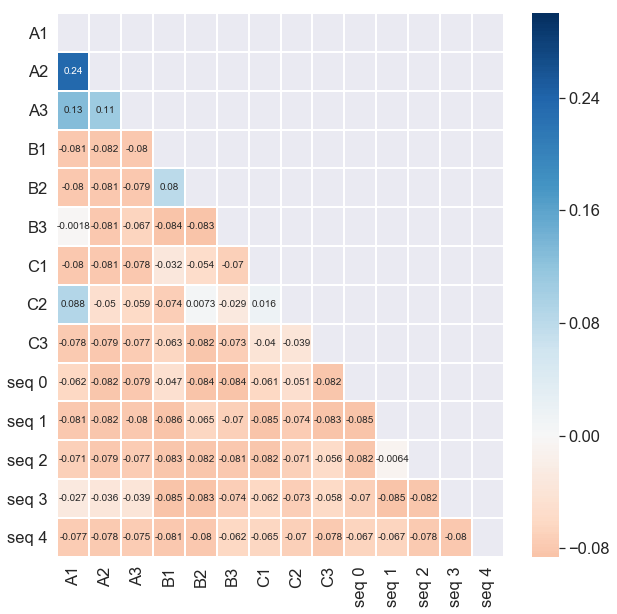

In [88]:
make_correlation_matrix(matrix_df_dropped_dataset)

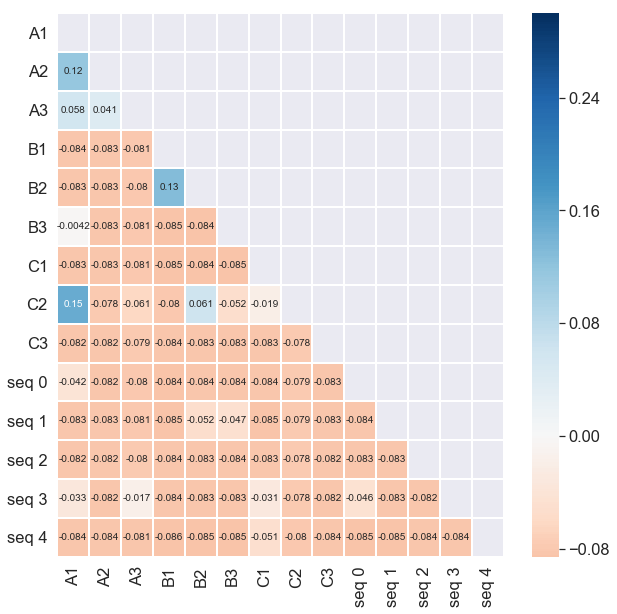

In [94]:
make_correlation_matrix(matrix_df_dropped_dataset_top)

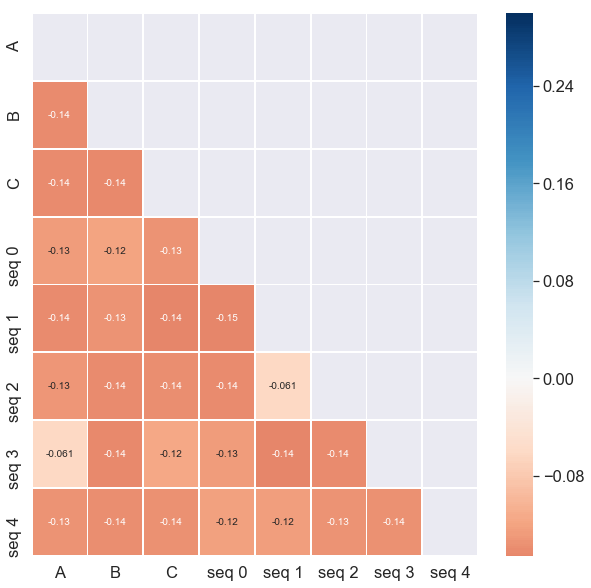

In [89]:
make_correlation_matrix(matrix_df_dropped_layer)

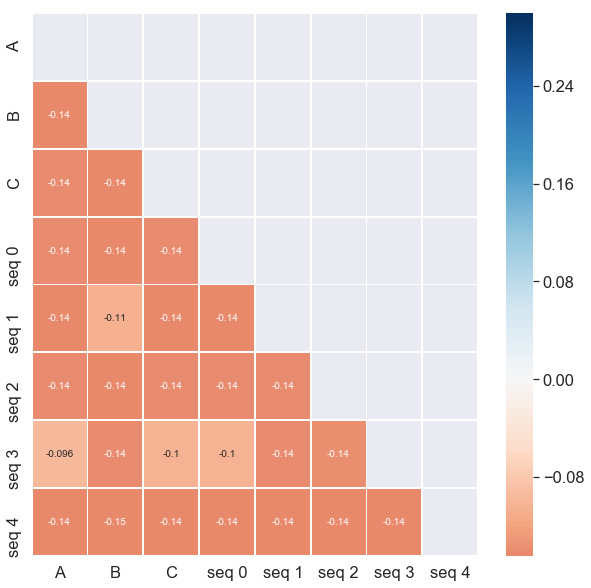

In [95]:
make_correlation_matrix(matrix_df_dropped_layer_top)

In [75]:
simulated_names_top

sim A1              sim A2              sim A3  \
0                 CYTB  ENSMUST00000111211             Ptgds-2   
1                  ND2            Slc1a2-1               Ptgds   
2   ENSMUST00000115856                Scd2             Ptgds-4   
3                  ND4              Slc1a2             Ptgds-1   
4              Sparcl1            Slc1a2-3             Ptgds-3   
5             Slc1a2-1             mt-Rnr2              Apoe-4   
6                  ND5            Slc1a2-2              Atp1a2   
7                 COX1             Ndrg2-1                Apoe   
8                 Car2                Glul              Apoe-5   
9   ENSMUST00000111211               Plpp3             Aldoc-1   
10             mt-Rnr1                  Qk                Apod   
11                Dio2           Slc1a2-11             Sparcl1   
12  ENSMUST00000108591             Aldoc-3              Apoe-8   
13                 Cpe            Slc1a2-8               Timp3   
14               Prex2               Paqr8  ENSMUST00000115856   
15               mt-Tv            Slc1a3-1              Igf2-3   
16                Aqp4               Aldoc               Ndrg2   
17             mt-Rnr2              Slc1a3              Slc1a3   
18              Camk2a            Tulp4-11             mt-Rnr1   
19             Mertk-1                COX1                Cst3   
20             Slc7a11            Atp1a2-2  ENSMUST00000053222   
21           Fam107a-2                Ncs1            Camk2a-1   
22              Myo6-3             Tulp4-9                Aqp4   
23  ENSMUST00000113259               Clu-1  ENSMUST00000174784   
24              Rorb-2               Gna13              Slc2a1   
25                Nfia                Gfap               Aldoc   
26             Ttyh1-2  ENSMUST00000109959            Slc1a2-1   
27  ENSMUST00000086397                Gja1               Neat1   
28              Nfia-2               Sfxn5              Syn3-2   
29               Mertk              Lrrc58  ENSMUST00000111211   

                sim B1              sim B2              sim B3  \
0               Lmo3-3  ENSMUST00000163463             Olfm1-4   
1   ENSMUST00000175336               Nptxr                Cdr1   
2   ENSMUST00000170784  ENSMUST00000089297             Olfm1-2   
3               Lmo3-5              Meg3-8               Vsnl1   
4                 Chn1             Nptxr-1                 ND2   
5   ENSMUST00000163463              Snhg11                Mdh1   
6             Atp2b2-2             Cacna1e  ENSMUST00000161001   
7               Lmo3-6               Scn2a                 Mmd   
8              Nptxr-1              Malat1            Tmsb4x-2   
9               Atp2b2              Ncdn-2                Nptn   
10  ENSMUST00000023462  ENSMUST00000159992              Snap25   
11              Rbfox1              Unc13a              Rtn4-1   
12           Arpp21-29               Map1a                Rtn4   
13               Nptxr              Atp1a3                 ND6   
14           Arpp21-21             Grin1-6              Atp1b1   
15            Pafah1b2  ENSMUST00000170784              Atp5a1   
16              Rtn1-2                Npcd              Syn1-1   
17  ENSMUST00000088752  ENSMUST00000163124                Snca   
18             Rab3a-2               Pgbd5              Tubb2a   
19                Lmo3             Pgbd5-5              Rtn4-3   
20            Stxbp1-2            Adgrb2-6                Chgb   
21              Stxbp1  ENSMUST00000074924               Basp1   
22  ENSMUST00000089297             Pcdh1-3              Nptn-1   
23             Nrxn3-7              Spock2                Rtn1   
24  ENSMUST00000101331               Tiam1              Rtn1-4   
25  ENSMUST00000067437  ENSMUST00000175336  ENSMUST00000166486   
26              Ncdn-1  ENSMUST00000066644              Snca-1   
27           Arhgef9-4           Arpp21-13            Atp5a1-1   
28                Arf3  ENSMUST00000171354            A

### Trying to convert everything to ENSMUST

In [107]:
preselected_IDs_all = preselected_names_all.copy()
#preselected_IDs_all = pd.DataFrame()
for col in ['seq 0','seq 1','seq 2','seq 3','seq 4']:
    symbol_list = preselected_names_all[col].values.tolist()
    
    mg_ID_dataframe = mg.querymany(symbol_list, scopes='symbol', fields='ensembl.transcript', species='mouse', as_dataframe=True, returnall=True)
    print(mg_ID_dataframe)
    id_list = mg_ID_dataframe['ensembl.transcript'].values.tolist()
    #print(id_list)
    
    #preselected_IDs_all.col = id_list 
    preselected_IDs_all[col] = id_list 
    #df.replace(symbol_list,id_list) #not sure this will work
preselected_IDs_all

querying 1-100...done.
Finished.
8 input query terms found dup hits:
	[('Cacng3', 2), ('Gm2163', 2), ('Kctd16', 2), ('Gm12027', 2), ('Gm42722', 2), ('St6galnac5', 2), ('C
1 input query terms found no hit:
	['Gm26848']
{'out':             _id     _score                                 ensembl.transcript  \
query                                                                           
Ryr2      20191  74.396610  [ENSMUST00000021750, ENSMUST00000170156, ENSMU...   
Syt17    110058  74.183540  [ENSMUST00000081574, ENSMUST00000203465, ENSMU...   
Camk1d   227541  75.562256  [ENSMUST00000044009, ENSMUST00000114987, ENSMU...   
Rfx3      19726  72.238800  [ENSMUST00000046898, ENSMUST00000165566, ENSMU...   
Kcnip4    80334  73.595590  [ENSMUST00000087395, ENSMUST00000101214, ENSMU...   
...         ...        ...                                                ...   
Sntb2     20650  73.234240                                                NaN   
Tmem158   72309  76.094790                   

KeyError: 'ensembl.transcript'

In [110]:
#trying gene instead of transcript
preselected_IDs_all = preselected_names_all.copy()
#preselected_IDs_all = pd.DataFrame()
for col in ['seq 0','seq 1','seq 2','seq 3','seq 4']:
    symbol_list = preselected_names_all[col].values.tolist()
    
    mg_ID_dataframe = mg.querymany(symbol_list, scopes='symbol', fields='ensembl.gene', species='mouse', as_dataframe=True, returnall=True)
    print(mg_ID_dataframe)
    print(mg_ID_dataframe.columns)
    id_list = mg_ID_dataframe['ensembl.gene'].values.tolist()
    #print(id_list)
    
    #preselected_IDs_all.col = id_list 
    preselected_IDs_all[col] = id_list 
    #df.replace(symbol_list,id_list) #not sure this will work
preselected_IDs_all

querying 1-100...done.
Finished.
8 input query terms found dup hits:
	[('Cacng3', 2), ('Gm2163', 2), ('Kctd16', 2), ('Gm12027', 2), ('Gm42722', 2), ('St6galnac5', 2), ('C
1 input query terms found no hit:
	['Gm26848']


ValueError: If using all scalar values, you must pass an index